## Normal Model

Model: Linear Regression
MAE = 0.97, Computation Time = 0.9044 seconds
Model: Ridge Regression
MAE = 0.97, Computation Time = 0.4999 seconds
Model: Lasso Regression
MAE = 0.98, Computation Time = 0.5449 seconds
Model: Decision Tree Regression
MAE = 0.96, Computation Time = 0.6752 seconds
Model: XGBoost Regression
MAE = 0.86, Computation Time = 16.8025 seconds

Best Model: XGBoost Regression
Best MAE: 0.86
Computation Time: 16.8025 seconds


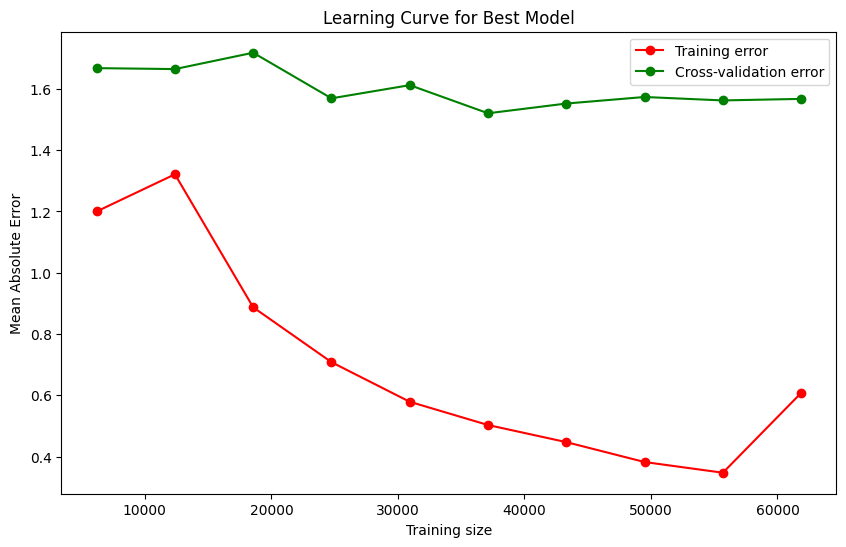

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import time
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('./model_input.csv')

# Convert reservation_time to datetime
data['reservation_time'] = pd.to_datetime(data['reservation_time'])

# Extract month, hour, and weekday from reservation_time
data['month'] = data['reservation_time'].dt.month
data['hour'] = data['reservation_time'].dt.hour
data['weekday'] = data['reservation_time'].dt.weekday

# One-hot encode categorical features
month_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
month_encoded = month_encoder.fit_transform(data[['month']])
month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=data.index)

hour_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
hour_encoded = hour_encoder.fit_transform(data[['hour']])
hour_encoded_df = pd.DataFrame(hour_encoded.toarray(), columns=hour_encoder.get_feature_names_out(['hour']), index=data.index)

high_chair_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
high_chair_encoded = high_chair_encoder.fit_transform(data[['high_chair_size']])
high_chair_encoded_df = pd.DataFrame(high_chair_encoded.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=data.index)

weekday_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
weekday_encoded = weekday_encoder.fit_transform(data[['weekday']])
weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=data.index)

# Combine all encoded features with the original data
data_encoded = pd.concat([data, month_encoded_df, hour_encoded_df, high_chair_encoded_df, weekday_encoded_df], axis=1)

# Drop rows with missing ETA values
data_encoded = data_encoded.dropna(subset=['ETA'])

# Define features including the hour and weekday features
features = ['party_size', 'queue_size'] + list(month_encoded_df.columns) + list(hour_encoded_df.columns) + list(high_chair_encoded_df.columns) + list(weekday_encoded_df.columns)
target = 'ETA'

# Function to handle negative and zero ETA values
def handle_negative_zero(df):
    df['ETA'] = df['ETA'].apply(lambda x: max(x, 0))  # Ensure no negative or zero ETA values
    return df

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
}

# Store results
results = {}
model_objects = {}

# Iterate over each model
for model_name, model in models.items():
    start_time = time.time()  # Start time for computation time

    # Create a copy of the data
    df_processed = data_encoded.copy()

    # Handle negative and zero ETA values
    df_processed = handle_negative_zero(df_processed)

    # Define features (X) and target (y)
    X = df_processed[features]
    y = df_processed[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate mean absolute error
    mae = mean_absolute_error(y_test, y_pred)

    end_time = time.time()  # End time for computation time
    computation_time = end_time - start_time

    # Store results and model object
    results[model_name] = {
        'MAE': mae,
        'Computation Time': computation_time
    }
    model_objects[model_name] = model

# Determine the best model based on MAE and computation time
best_model_name = None
best_mae = float('inf')
best_computation_time = float('inf')

for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"MAE = {metrics['MAE']:.2f}, Computation Time = {metrics['Computation Time']:.4f} seconds")
    if metrics['MAE'] < best_mae or (metrics['MAE'] == best_mae and metrics['Computation Time'] < best_computation_time):
        best_model_name = model_name
        best_mae = metrics['MAE']
        best_computation_time = metrics['Computation Time']

best_model = model_objects[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best MAE: {best_mae:.2f}")
print(f"Computation Time: {best_computation_time:.4f} seconds")

# Learning curve analysis for the best model
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve for Best Model')
plt.legend(loc='best')
plt.show()


In [4]:
def prepare_input_data(input_data, month_encoder, hour_encoder, high_chair_encoder, weekday_encoder):
    input_df = pd.DataFrame([input_data])
    input_df['reservation_time'] = pd.to_datetime(input_df['reservation_time'])
    input_df['month'] = input_df['reservation_time'].dt.month
    input_df['hour'] = input_df['reservation_time'].dt.hour
    input_df['weekday'] = input_df['reservation_time'].dt.weekday

    month_encoded = month_encoder.transform(input_df[['month']])
    month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=input_df.index)

    hour_encoded = hour_encoder.transform(input_df[['hour']])
    hour_encoded_df = pd.DataFrame(hour_encoded.toarray(), columns=hour_encoder.get_feature_names_out(['hour']), index=input_df.index)

    high_chair_encoded = high_chair_encoder.transform(input_df[['high_chair_size']])
    high_chair_encoded_df = pd.DataFrame(high_chair_encoded.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=input_df.index)

    weekday_encoded = weekday_encoder.transform(input_df[['weekday']])
    weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=input_df.index)

    input_encoded = pd.concat([input_df, month_encoded_df, hour_encoded_df, high_chair_encoded_df, weekday_encoded_df], axis=1)
    return input_encoded[features]

# Example input for prediction
input_data = {
    'reservation_time': '2024-07-16 00:30:00',
    'party_size': 8,
    'high_chair_size': 0,
    'queue_size': 9
}

# Prepare the input data
input_encoded = prepare_input_data(input_data, month_encoder, hour_encoder, high_chair_encoder, weekday_encoder)

# Predict using the best model
prediction = best_model.predict(input_encoded)
print(f"Predicted ETA: {prediction[0]:.2f} minutes")

Predicted ETA: 23.02 minutes


Model: Linear Regression
MAE = 0.97, Computation Time = 2.6854 seconds
Model: Ridge Regression
MAE = 0.97, Computation Time = 0.6533 seconds
Model: Lasso Regression
MAE = 0.98, Computation Time = 0.4896 seconds
Model: Decision Tree Regression
MAE = 0.95, Computation Time = 0.6027 seconds
Model: XGBoost Regression
MAE = 0.86, Computation Time = 17.1919 seconds

Best Model: XGBoost Regression
Best MAE: 0.86
Computation Time: 17.1919 seconds
Predictions and errors saved to ./predicted_eta_normal.csv


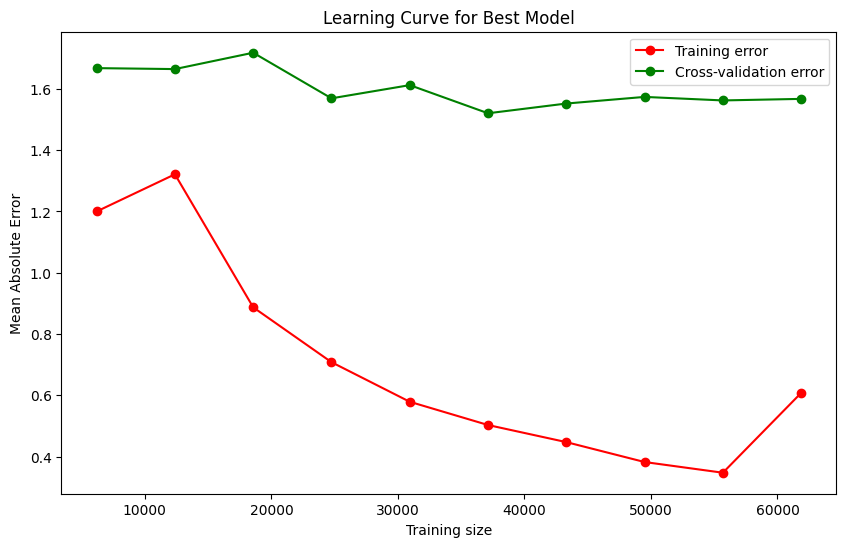

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor  # Import XGBoost
from sklearn.preprocessing import OneHotEncoder
import time

# Load the data
data = pd.read_csv('./model_input.csv')

# Convert reservation_time to datetime
data['reservation_time'] = pd.to_datetime(data['reservation_time'])

# Extract month, hour, and weekday from reservation_time
data['month'] = data['reservation_time'].dt.month
data['hour'] = data['reservation_time'].dt.hour
data['weekday'] = data['reservation_time'].dt.weekday

# One-hot encode the categorical features
month_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
month_encoded = month_encoder.fit_transform(data[['month']])
month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=data.index)

hour_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
hour_encoded = hour_encoder.fit_transform(data[['hour']])
hour_encoded_df = pd.DataFrame(hour_encoded.toarray(), columns=hour_encoder.get_feature_names_out(['hour']), index=data.index)

weekday_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
weekday_encoded = weekday_encoder.fit_transform(data[['weekday']])
weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=data.index)

high_chair_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
high_chair_encoded = high_chair_encoder.fit_transform(data[['high_chair_size']])
high_chair_encoded_df = pd.DataFrame(high_chair_encoded.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=data.index)

# Combine all encoded features with the original data
data_encoded = pd.concat([data, month_encoded_df, hour_encoded_df, weekday_encoded_df, high_chair_encoded_df], axis=1)

# Define features including the hour and weekday features
features = ['party_size', 'queue_size'] + list(month_encoded_df.columns) + list(hour_encoded_df.columns) + list(weekday_encoded_df.columns) + list(high_chair_encoded_df.columns)
target = 'ETA'

# Function to handle negative or zero ETA values
def handle_negative_zero(df):
    df['ETA'] = df['ETA'].apply(lambda x: max(x, 0))
    return df

# Remove rows with missing ETA values
data_encoded = data_encoded.dropna(subset=['ETA'])

# Dictionary of models to be tested
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)  
}

# Training and evaluating models
results = {}
for model_name, model in models.items():
    start_time = time.time()
    df_processed = data_encoded.copy()
    df_processed = handle_negative_zero(df_processed)
    X = df_processed[features]
    y = df_processed[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    end_time = time.time()
    computation_time = end_time - start_time
    results[model_name] = {'MAE': mae, 'Computation Time': computation_time}

# Select the best model based on MAE
best_model = None
best_mae = float('inf')
best_computation_time = float('inf')
for model, metrics in results.items():
    print(f"Model: {model}")
    print(f"MAE = {metrics['MAE']:.2f}, Computation Time = {metrics['Computation Time']:.4f} seconds")
    if metrics['MAE'] < best_mae or (metrics['MAE'] == best_mae and metrics['Computation Time'] < best_computation_time):
        best_model = model
        best_mae = metrics['MAE']
        best_computation_time = metrics['Computation Time']
print(f"\nBest Model: {best_model}")
print(f"Best MAE: {best_mae:.2f}")
print(f"Computation Time: {best_computation_time:.4f} seconds")

# Predicting ETA for each row and calculating the error
best_model_instance = models[best_model]

# Ensure the feature DataFrame includes the non-one-hot encoded columns
data_encoded_features = pd.concat([data[['party_size', 'queue_size']], month_encoded_df, hour_encoded_df, weekday_encoded_df, high_chair_encoded_df], axis=1)

# Predict ETA
data['predicted_eta'] = best_model_instance.predict(data_encoded_features)
data['error'] = data['ETA'] - data['predicted_eta']

# Save the results to a new CSV file
output_path = './predicted_eta_normal.csv'
data.to_csv(output_path, index=False)

print(f"Predictions and errors saved to {output_path}")

train_sizes, train_scores, test_scores = learning_curve(
    best_model_instance, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve for Best Model')
plt.legend(loc='best')
plt.show()


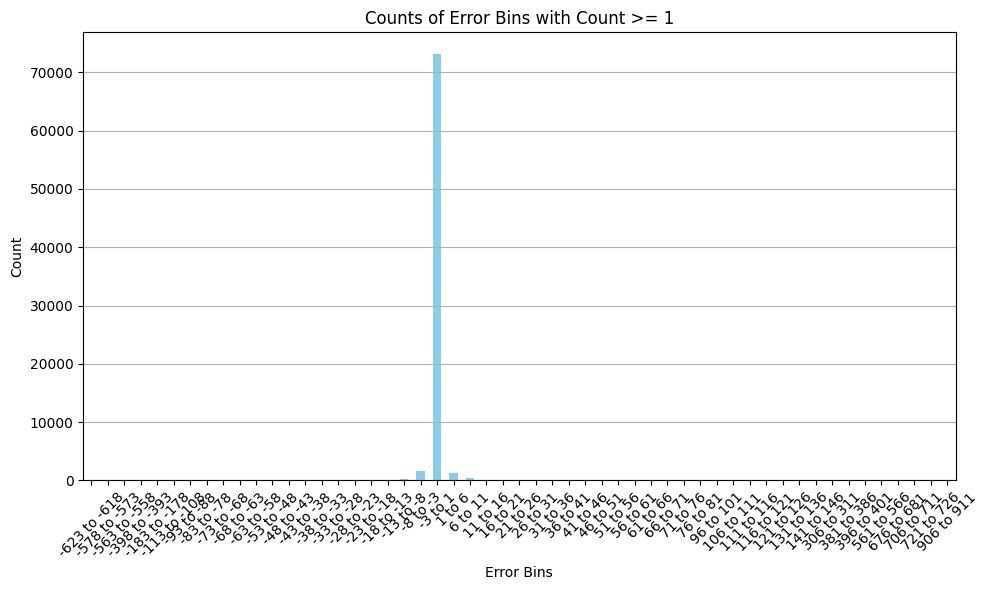

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = './predicted_eta_normal.csv'
data = pd.read_csv(data_path)

min_error = data['error'].min()
max_error = data['error'].max()

bin_edges = np.arange(min_error, max_error + 5, 5)

custom_bin_labels = [f"{int(bin_edges[i])} to {int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

data['error_bin'] = pd.cut(data['error'], bins=bin_edges, labels=custom_bin_labels, include_lowest=True, right=False)

bin_counts = data['error_bin'].value_counts().sort_index()

filtered_bins = bin_counts[bin_counts >= 1]

plt.figure(figsize=(10, 6))
filtered_bins.plot(kind='bar', color='skyblue')
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Counts of Error Bins with Count >= 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

data.to_csv('./predicted_eta_normal.csv')

In [8]:
highest_count_bin = filtered_bins.idxmax()
filtered_data = data[data['error_bin'] == highest_count_bin]
sorted_data = filtered_data.sort_values(by='error_bin')
weekday_counts = sorted_data['weekday'].value_counts().sort_index()

In [11]:
print(highest_count_bin)
print(weekday_counts)

-3 to 1
weekday
0     4405
1     4942
2     7681
3     8150
4    10636
5    18750
6    18645
Name: count, dtype: int64


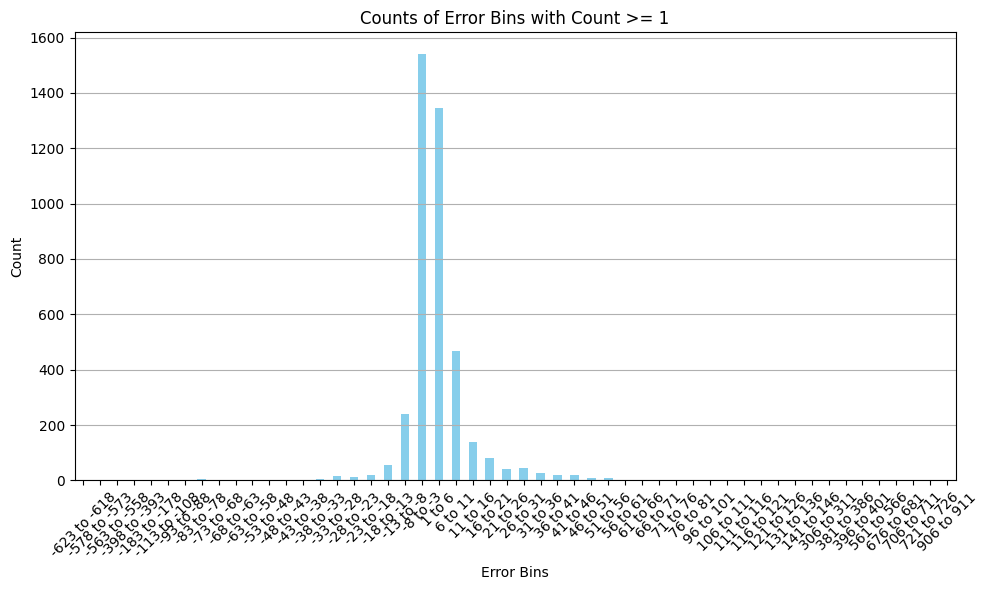

In [12]:
data_bin = ['-3 to 1']
filtered_df = data[~data['error_bin'].isin(data_bin)]
bin_counts = filtered_df['error_bin'].value_counts().sort_index()

filtered_bins = bin_counts[bin_counts >= 1]

plt.figure(figsize=(10, 6))
filtered_bins.plot(kind='bar', color='skyblue')
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Counts of Error Bins with Count >= 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


## Stratified Sampling

In [14]:
import pandas as pd

# Sample data
data = pd.read_csv('./model_input.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Convert reservation_time to datetime
df['reservation_time'] = pd.to_datetime(df['reservation_time'])

# Extract the hour from reservation_time
df['hour'] = df['reservation_time'].dt.hour

# Create bins for hours
bins = [f"{hour}-{hour+1}" for hour in range(24)]
df['hour_bin'] = pd.cut(df['hour'], bins=range(25), right=False, labels=bins)

print(df[['reservation_time', 'hour_bin']])

               reservation_time hour_bin
0     2020-10-24 21:41:53+00:00    21-22
1     2020-10-24 21:42:32+00:00    21-22
2     2020-10-24 21:53:45+00:00    21-22
3     2020-10-24 21:54:09+00:00    21-22
4     2020-10-24 21:58:08+00:00    21-22
...                         ...      ...
77340 2024-06-30 01:44:23+00:00      1-2
77341 2024-06-30 01:47:41+00:00      1-2
77342 2024-07-03 01:33:07+00:00      1-2
77343 2024-07-04 01:38:22+00:00      1-2
77344 2024-07-04 01:45:45+00:00      1-2

[77345 rows x 2 columns]


In [15]:
df.to_csv('./model_input.csv')

In [16]:
from sklearn.model_selection import train_test_split

hour_bin_counts = df['hour_bin'].value_counts()
print(hour_bin_counts)

# Identify bins with less than 2 samples
sparse_bins = hour_bin_counts[hour_bin_counts < 2].index.tolist()

# Option 1: Remove sparse bins
df_filtered = df[~df['hour_bin'].isin(sparse_bins)]

# Option 2: Merge sparse bins (e.g., merge with neighboring bins)
# Example: Assuming 'hour_bin' values are integers and sorted, merge sparse bins with the previous bin
# This requires custom logic depending on your binning strategy

# Perform stratified sampling on the filtered dataset
train_df, test_df = train_test_split(
    df_filtered,
    test_size=0.2,  # Adjust the test size as needed
    stratify=df_filtered['hour_bin']
)

# Verify the stratification by checking the distribution in both sets
print("Train set hour_bin distribution:")
print(train_df['hour_bin'].value_counts(normalize=True))

print("Test set hour_bin distribution:")
print(test_df['hour_bin'].value_counts(normalize=True))

# Save the resulting data
train_df.to_csv('train_set.csv', index=False)
test_df.to_csv('test_set.csv', index=False)

print("Training and test sets have been saved successfully.")

hour_bin
0-1      13271
23-24    12001
17-18     9578
1-2       8730
18-19     8130
16-17     7228
22-23     6841
19-20     4130
15-16     2333
21-22     2047
2-3       1976
20-21      968
3-4         48
14-15       14
4-5         13
12-13       11
6-7          7
5-6          6
13-14        4
8-9          3
11-12        2
9-10         2
10-11        1
7-8          1
Name: count, dtype: int64
Train set hour_bin distribution:
hour_bin
0-1      0.171591
23-24    0.155170
17-18    0.123832
1-2      0.112875
18-19    0.105117
16-17    0.093448
22-23    0.088454
19-20    0.053399
15-16    0.030158
21-22    0.026473
2-3      0.025552
20-21    0.012509
3-4      0.000614
14-15    0.000178
4-5      0.000162
12-13    0.000145
6-7      0.000097
5-6      0.000081
13-14    0.000048
11-12    0.000032
9-10     0.000032
8-9      0.000032
10-11    0.000000
7-8      0.000000
Name: proportion, dtype: float64
Test set hour_bin distribution:
hour_bin
0-1      0.171569
23-24    0.155149
17-18    0.123861
1-2

Model: Linear Regression
MAE = 0.96, Computation Time = 0.3335 seconds
Model: Ridge Regression
MAE = 0.96, Computation Time = 0.1143 seconds
Model: Lasso Regression
MAE = 1.01, Computation Time = 0.2020 seconds
Model: Decision Tree Regression
MAE = 0.77, Computation Time = 0.1003 seconds
Model: XGBoost Regression
MAE = 0.75, Computation Time = 0.3560 seconds

Best Model: XGBoost Regression
Best MAE: 0.75
Computation Time: 0.3560 seconds
Predicted ETA: 36.69


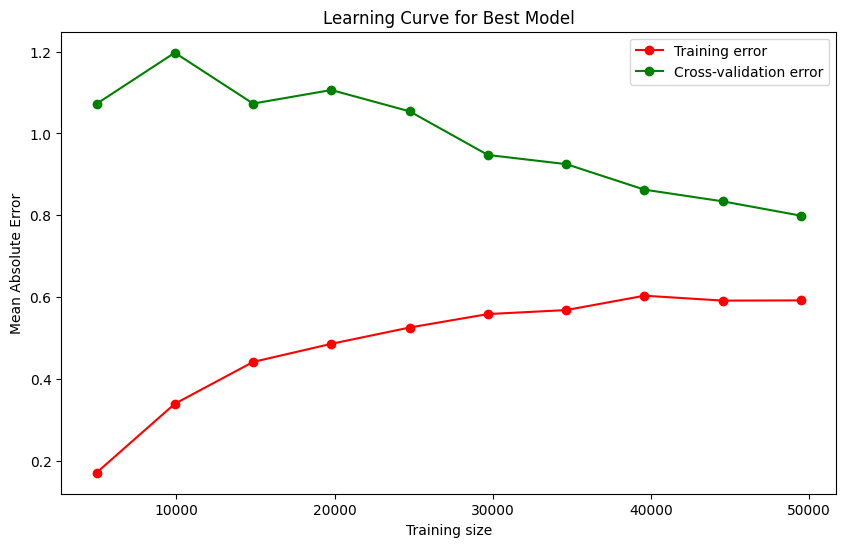

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import time

# Load the stratified train and test sets
train_data = pd.read_csv('train_set.csv')
test_data = pd.read_csv('test_set.csv')

# Convert reservation_time to datetime
train_data['reservation_time'] = pd.to_datetime(train_data['reservation_time'])
test_data['reservation_time'] = pd.to_datetime(test_data['reservation_time'])

# Extract month, hour, and weekday from reservation_time
for df in [train_data, test_data]:
    df['month'] = df['reservation_time'].dt.month
    df['hour'] = df['reservation_time'].dt.hour
    df['weekday'] = df['reservation_time'].dt.weekday

# One-hot encode categorical features
month_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
month_encoded_train = month_encoder.fit_transform(train_data[['month']])
month_encoded_train_df = pd.DataFrame(month_encoded_train.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=train_data.index)

high_chair_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
high_chair_encoded_train = high_chair_encoder.fit_transform(train_data[['high_chair_size']])
high_chair_encoded_train_df = pd.DataFrame(high_chair_encoded_train.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=train_data.index)

weekday_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
weekday_encoded_train = weekday_encoder.fit_transform(train_data[['weekday']])
weekday_encoded_train_df = pd.DataFrame(weekday_encoded_train.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=train_data.index)

# Combine all encoded features with the original data
train_data_encoded = pd.concat([train_data, month_encoded_train_df, high_chair_encoded_train_df, weekday_encoded_train_df], axis=1)

# Apply the same encoding to the test data
month_encoded_test = month_encoder.transform(test_data[['month']])
month_encoded_test_df = pd.DataFrame(month_encoded_test.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=test_data.index)

high_chair_encoded_test = high_chair_encoder.transform(test_data[['high_chair_size']])
high_chair_encoded_test_df = pd.DataFrame(high_chair_encoded_test.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=test_data.index)

weekday_encoded_test = weekday_encoder.transform(test_data[['weekday']])
weekday_encoded_test_df = pd.DataFrame(weekday_encoded_test.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=test_data.index)

# Combine all encoded features with the original data
test_data_encoded = pd.concat([test_data, month_encoded_test_df, high_chair_encoded_test_df, weekday_encoded_test_df], axis=1)

# Define features including the hour and weekday features
features = ['party_size', 'queue_size', 'hour'] + list(month_encoded_train_df.columns) + list(high_chair_encoded_train_df.columns) + list(weekday_encoded_train_df.columns)
target = 'ETA'

# Function to handle negative and zero ETA values
def handle_negative_zero(df):
    df['ETA'] = df['ETA'].apply(lambda x: max(x, 0))
    return df

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
}

# Store results
results = {}
model_objects = {}

# Iterate over each model
for model_name, model in models.items():
    start_time = time.time()  # Start time for computation time

    # Create copies of the data
    train_processed = train_data_encoded.copy()
    test_processed = test_data_encoded.copy()

    # Handle negative and zero ETA values
    train_processed = handle_negative_zero(train_processed)
    test_processed = handle_negative_zero(test_processed)

    # Define features (X) and target (y)
    X_train = train_processed[features]
    y_train = train_processed[target]
    X_test = test_processed[features]
    y_test = test_processed[target]

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate mean absolute error
    mae = mean_absolute_error(y_test, y_pred)

    end_time = time.time()  # End time for computation time
    computation_time = end_time - start_time

    # Store results and model object
    results[model_name] = {
        'MAE': mae,
        'Computation Time': computation_time
    }
    model_objects[model_name] = model

# Determine the best model based on MAE and computation time
best_model_name = None
best_mae = float('inf')
best_computation_time = float('inf')

for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"MAE = {metrics['MAE']:.2f}, Computation Time = {metrics['Computation Time']:.4f} seconds")
    if metrics['MAE'] < best_mae or (metrics['MAE'] == best_mae and metrics['Computation Time'] < best_computation_time):
        best_model_name = model_name
        best_mae = metrics['MAE']
        best_computation_time = metrics['Computation Time']

best_model = model_objects[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best MAE: {best_mae:.2f}")
print(f"Computation Time: {best_computation_time:.4f} seconds")

# Function to prepare input data for prediction
def prepare_input_data(input_data, month_encoder, high_chair_encoder, weekday_encoder):
    input_df = pd.DataFrame([input_data])
    input_df['reservation_time'] = pd.to_datetime(input_df['reservation_time'])
    input_df['month'] = input_df['reservation_time'].dt.month
    input_df['hour'] = input_df['reservation_time'].dt.hour
    input_df['weekday'] = input_df['reservation_time'].dt.weekday

    month_encoded = month_encoder.transform(input_df[['month']])
    month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=input_df.index)

    high_chair_encoded = high_chair_encoder.transform(input_df[['high_chair_size']])
    high_chair_encoded_df = pd.DataFrame(high_chair_encoded.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=input_df.index)

    weekday_encoded = weekday_encoder.transform(input_df[['weekday']])
    weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=input_df.index)

    input_encoded = pd.concat([input_df, month_encoded_df, high_chair_encoded_df, weekday_encoded_df], axis=1)
    return input_encoded[features]

# Example of preparing input data for prediction
input_data = {
    'reservation_time': '2024-07-16 00:30:00',
    'party_size': 8,
    'high_chair_size': 0,
    'queue_size': 8
}

prepared_input = prepare_input_data(input_data, month_encoder, high_chair_encoder, weekday_encoder)
predicted_eta = best_model.predict(prepared_input)
print(f"Predicted ETA: {predicted_eta[0]:.2f}")

# Plot the learning curve for the best model
X = train_processed[features]
y = train_processed[target]

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve for Best Model')
plt.legend(loc='best')
plt.show()


Model: Linear Regression
MAE = 0.96, Computation Time = 0.1119 seconds
Model: Ridge Regression
MAE = 0.96, Computation Time = 0.0805 seconds
Model: Lasso Regression
MAE = 1.01, Computation Time = 0.1074 seconds
Model: Decision Tree Regression
MAE = 0.77, Computation Time = 0.1083 seconds
Model: XGBoost Regression
MAE = 0.75, Computation Time = 0.5225 seconds

Best Model: XGBoost Regression
Best MAE: 0.75
Computation Time: 0.5225 seconds
Predicted ETA: 36.69


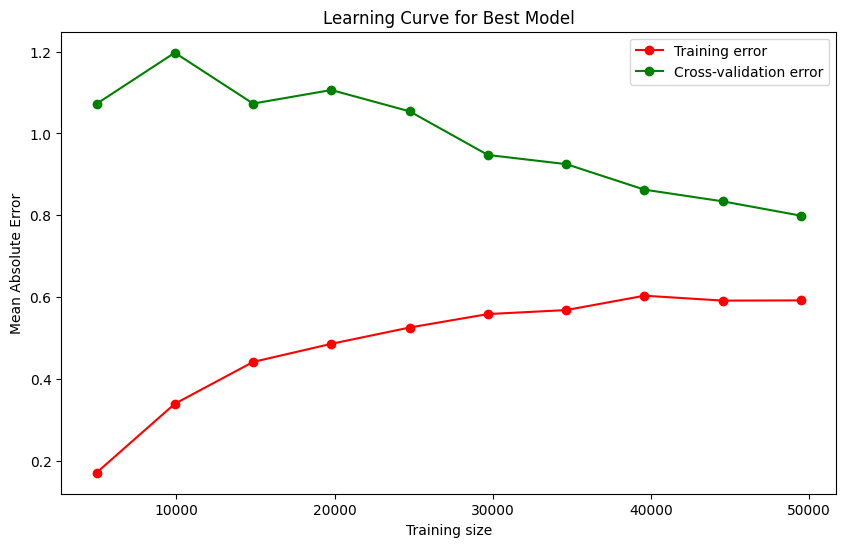

Predictions for all records in test set saved successfully.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import time

# Load the stratified train and test sets
train_data = pd.read_csv('train_set.csv')
test_data = pd.read_csv('test_set.csv')

# Convert reservation_time to datetime
train_data['reservation_time'] = pd.to_datetime(train_data['reservation_time'])
test_data['reservation_time'] = pd.to_datetime(test_data['reservation_time'])

# Extract month, hour, and weekday from reservation_time
for df in [train_data, test_data]:
    df['month'] = df['reservation_time'].dt.month
    df['hour'] = df['reservation_time'].dt.hour
    df['weekday'] = df['reservation_time'].dt.weekday

# One-hot encode categorical features
month_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
month_encoded_train = month_encoder.fit_transform(train_data[['month']])
month_encoded_train_df = pd.DataFrame(month_encoded_train.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=train_data.index)

high_chair_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
high_chair_encoded_train = high_chair_encoder.fit_transform(train_data[['high_chair_size']])
high_chair_encoded_train_df = pd.DataFrame(high_chair_encoded_train.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=train_data.index)

weekday_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
weekday_encoded_train = weekday_encoder.fit_transform(train_data[['weekday']])
weekday_encoded_train_df = pd.DataFrame(weekday_encoded_train.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=train_data.index)

# Combine all encoded features with the original data
train_data_encoded = pd.concat([train_data, month_encoded_train_df, high_chair_encoded_train_df, weekday_encoded_train_df], axis=1)

# Apply the same encoding to the test data
month_encoded_test = month_encoder.transform(test_data[['month']])
month_encoded_test_df = pd.DataFrame(month_encoded_test.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=test_data.index)

high_chair_encoded_test = high_chair_encoder.transform(test_data[['high_chair_size']])
high_chair_encoded_test_df = pd.DataFrame(high_chair_encoded_test.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=test_data.index)

weekday_encoded_test = weekday_encoder.transform(test_data[['weekday']])
weekday_encoded_test_df = pd.DataFrame(weekday_encoded_test.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=test_data.index)

# Combine all encoded features with the original data
test_data_encoded = pd.concat([test_data, month_encoded_test_df, high_chair_encoded_test_df, weekday_encoded_test_df], axis=1)

# Define features including the hour and weekday features
features = ['party_size', 'queue_size', 'hour'] + list(month_encoded_train_df.columns) + list(high_chair_encoded_train_df.columns) + list(weekday_encoded_train_df.columns)
target = 'ETA'

# Function to handle negative and zero ETA values
def handle_negative_zero(df):
    df['ETA'] = df['ETA'].apply(lambda x: max(x, 0))
    return df

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
}

# Store results
results = {}
model_objects = {}

# Iterate over each model
for model_name, model in models.items():
    start_time = time.time()  # Start time for computation time

    # Create copies of the data
    train_processed = train_data_encoded.copy()
    test_processed = test_data_encoded.copy()

    # Handle negative and zero ETA values
    train_processed = handle_negative_zero(train_processed)
    test_processed = handle_negative_zero(test_processed)

    # Define features (X) and target (y)
    X_train = train_processed[features]
    y_train = train_processed[target]
    X_test = test_processed[features]
    y_test = test_processed[target]

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate mean absolute error
    mae = mean_absolute_error(y_test, y_pred)

    end_time = time.time()  # End time for computation time
    computation_time = end_time - start_time

    # Store results and model object
    results[model_name] = {
        'MAE': mae,
        'Computation Time': computation_time
    }
    model_objects[model_name] = model

# Determine the best model based on MAE and computation time
best_model_name = None
best_mae = float('inf')
best_computation_time = float('inf')

for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"MAE = {metrics['MAE']:.2f}, Computation Time = {metrics['Computation Time']:.4f} seconds")
    if metrics['MAE'] < best_mae or (metrics['MAE'] == best_mae and metrics['Computation Time'] < best_computation_time):
        best_model_name = model_name
        best_mae = metrics['MAE']
        best_computation_time = metrics['Computation Time']

best_model = model_objects[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best MAE: {best_mae:.2f}")
print(f"Computation Time: {best_computation_time:.4f} seconds")

# Function to prepare input data for prediction
def prepare_input_data(input_data, month_encoder, high_chair_encoder, weekday_encoder):
    input_df = pd.DataFrame([input_data])
    input_df['reservation_time'] = pd.to_datetime(input_df['reservation_time'])
    input_df['month'] = input_df['reservation_time'].dt.month
    input_df['hour'] = input_df['reservation_time'].dt.hour
    input_df['weekday'] = input_df['reservation_time'].dt.weekday

    month_encoded = month_encoder.transform(input_df[['month']])
    month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=input_df.index)

    high_chair_encoded = high_chair_encoder.transform(input_df[['high_chair_size']])
    high_chair_encoded_df = pd.DataFrame(high_chair_encoded.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=input_df.index)

    weekday_encoded = weekday_encoder.transform(input_df[['weekday']])
    weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=input_df.index)

    input_encoded = pd.concat([input_df, month_encoded_df, high_chair_encoded_df, weekday_encoded_df], axis=1)
    return input_encoded[features]

# Example of preparing input data for prediction
input_data = {
    'reservation_time': '2024-07-16 00:30:00',
    'party_size': 8,
    'high_chair_size': 0,
    'queue_size': 8

}

prepared_input = prepare_input_data(input_data, month_encoder, high_chair_encoder, weekday_encoder)
predicted_eta = best_model.predict(prepared_input)
print(f"Predicted ETA: {predicted_eta[0]:.2f}")

# Plot the learning curve for the best model
X = train_processed[features]
y = train_processed[target]

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve for Best Model')
plt.legend(loc='best')
plt.show()

# Predict ETA for all records in the test set and save as predicted_eta
test_data_encoded = handle_negative_zero(test_data_encoded)
X_test_all = test_data_encoded[features]
predicted_eta_all = best_model.predict(X_test_all)

test_data_encoded['predicted_eta'] = predicted_eta_all
# Predict ETA
test_data_encoded['predicted_eta'] = best_model.predict(X_test_all)
test_data_encoded['error'] = data['ETA'] - test_data_encoded['predicted_eta']

test_data_encoded.to_csv('./test_set_predicted.csv', index=False)

print("Predictions for all records in test set saved successfully.")


## Training Error (Red Line):

The training error starts low and consistently remains low as the training size increases. This indicates that the model fits the training data very well and can capture even complex patterns, potentially including noise in the data.

## Cross-Validation Error (Green Line):

The cross-validation error begins relatively high and decreases slightly with increased training size but consistently remains significantly higher than the training error.
The gap between the training error and the cross-validation error highlights overfitting issues. Overfitting occurs when the model performs exceptionally well on the training data but struggles to generalize to unseen data, such as validation or test datasets.

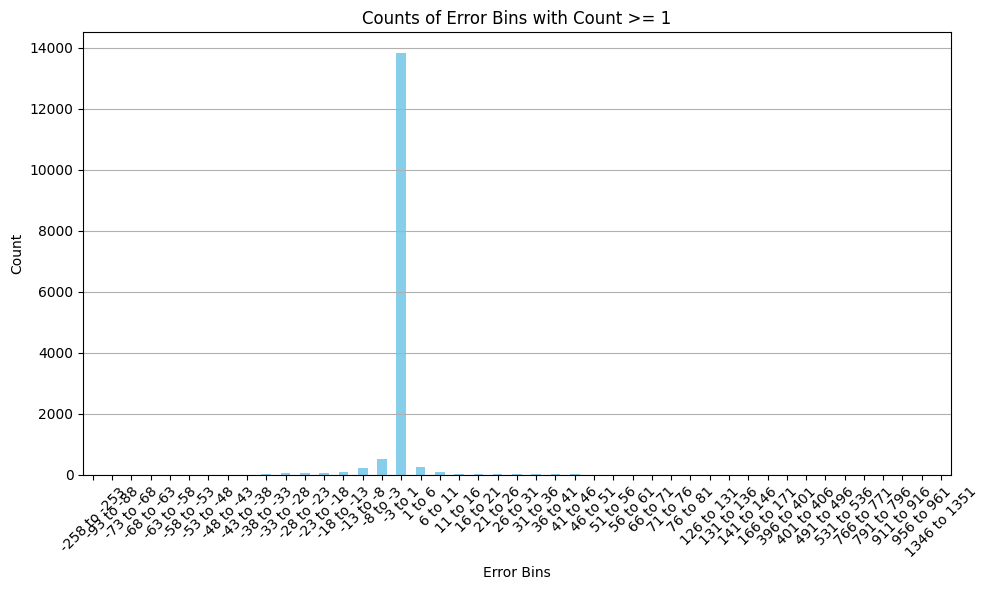

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = './test_set_predicted.csv'
data = pd.read_csv(data_path)

min_error = data['error'].min()
max_error = data['error'].max()

bin_edges = np.arange(min_error, max_error + 5, 5)

custom_bin_labels = [f"{int(bin_edges[i])} to {int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

data['error_bin'] = pd.cut(data['error'], bins=bin_edges, labels=custom_bin_labels, include_lowest=True, right=False)

bin_counts = data['error_bin'].value_counts().sort_index()

filtered_bins = bin_counts[bin_counts >= 1]

plt.figure(figsize=(10, 6))
filtered_bins.plot(kind='bar', color='skyblue')
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Counts of Error Bins with Count >= 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

data.to_csv('./test_set_predicted.csv')

In [22]:
highest_count_bin = filtered_bins.idxmax()
filtered_data = data[data['error_bin'] == highest_count_bin]
sorted_data = filtered_data.sort_values(by='error_bin')
weekday_counts = sorted_data['weekday'].value_counts().sort_index()

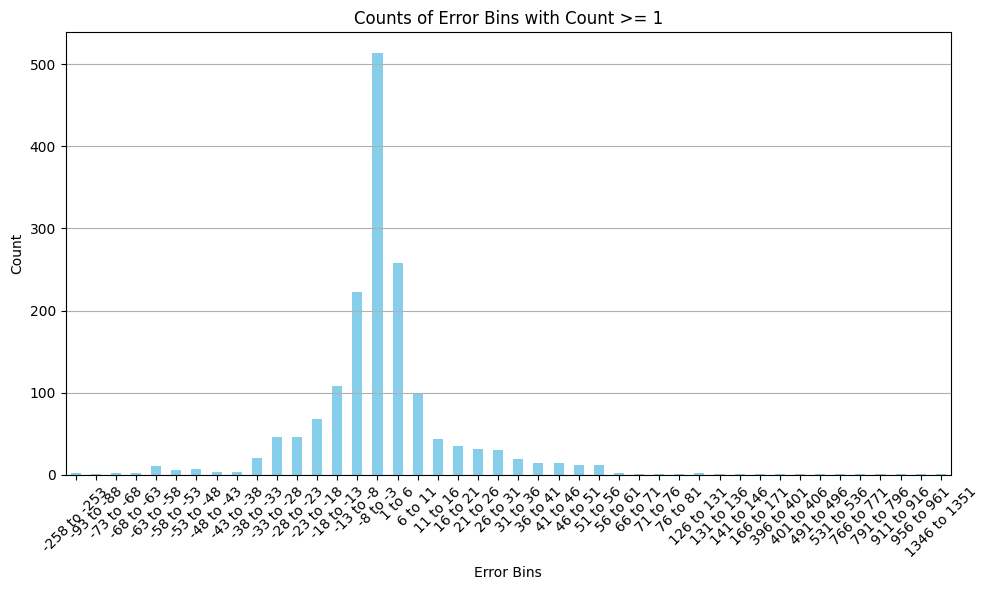

In [23]:
data_bin = ['-3 to 1']
filtered_df = data[~data['error_bin'].isin(data_bin)]
bin_counts = filtered_df['error_bin'].value_counts().sort_index()

filtered_bins = bin_counts[bin_counts >= 1]

plt.figure(figsize=(10, 6))
filtered_bins.plot(kind='bar', color='skyblue')
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Counts of Error Bins with Count >= 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


## Hold out method

Model: Linear Regression
Validation MAE = 1.08, Test MAE = 0.94, Computation Time = 0.5323 seconds
Model: Ridge Regression
Validation MAE = 1.08, Test MAE = 0.94, Computation Time = 0.1274 seconds
Model: Lasso Regression
Validation MAE = 1.09, Test MAE = 0.96, Computation Time = 0.1236 seconds
Model: Decision Tree Regression
Validation MAE = 0.88, Test MAE = 0.86, Computation Time = 0.1294 seconds
Model: XGBoost Regression
Validation MAE = 0.84, Test MAE = 0.74, Computation Time = 0.3597 seconds

Best Model: XGBoost Regression
Best Validation MAE: 0.84
Computation Time: 0.3597 seconds
Predicted ETA: 27.15


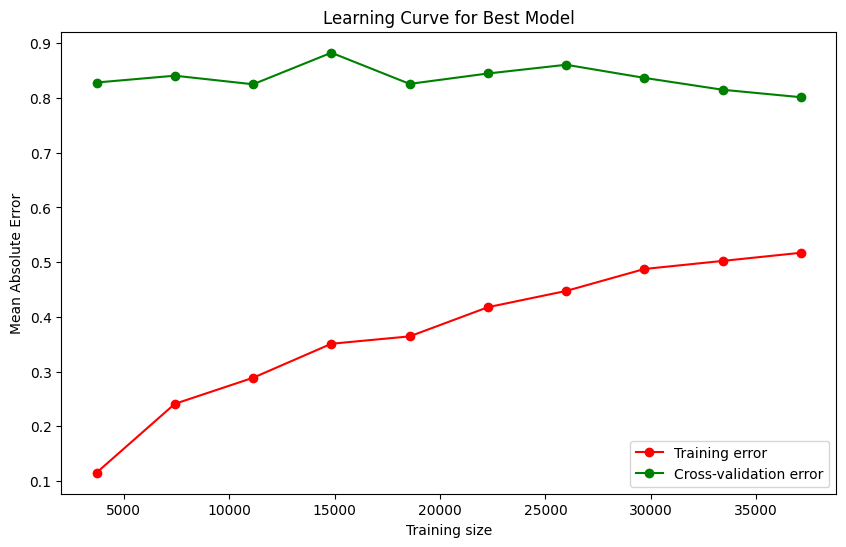

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import time

# Load the complete dataset
data = pd.read_csv('./model_input.csv')

# Convert reservation_time to datetime
data['reservation_time'] = pd.to_datetime(data['reservation_time'])

# Extract month, hour, and weekday from reservation_time
data['month'] = data['reservation_time'].dt.month
data['hour'] = data['reservation_time'].dt.hour
data['weekday'] = data['reservation_time'].dt.weekday

# Split data into train+validation and hold-out test sets
train_val_data, hold_out_data = train_test_split(data, test_size=0.2, random_state=42)

# Further split train_val_data into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# One-hot encode categorical features
month_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
month_encoded_train = month_encoder.fit_transform(train_data[['month']])
month_encoded_train_df = pd.DataFrame(month_encoded_train.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=train_data.index)

high_chair_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
high_chair_encoded_train = high_chair_encoder.fit_transform(train_data[['high_chair_size']])
high_chair_encoded_train_df = pd.DataFrame(high_chair_encoded_train.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=train_data.index)

weekday_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
weekday_encoded_train = weekday_encoder.fit_transform(train_data[['weekday']])
weekday_encoded_train_df = pd.DataFrame(weekday_encoded_train.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=train_data.index)

# Combine all encoded features with the original data
train_data_encoded = pd.concat([train_data, month_encoded_train_df, high_chair_encoded_train_df, weekday_encoded_train_df], axis=1)

# Apply the same encoding to the validation and hold-out test data
month_encoded_val = month_encoder.transform(val_data[['month']])
month_encoded_val_df = pd.DataFrame(month_encoded_val.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=val_data.index)

high_chair_encoded_val = high_chair_encoder.transform(val_data[['high_chair_size']])
high_chair_encoded_val_df = pd.DataFrame(high_chair_encoded_val.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=val_data.index)

weekday_encoded_val = weekday_encoder.transform(val_data[['weekday']])
weekday_encoded_val_df = pd.DataFrame(weekday_encoded_val.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=val_data.index)

# Combine all encoded features with the original data
val_data_encoded = pd.concat([val_data, month_encoded_val_df, high_chair_encoded_val_df, weekday_encoded_val_df], axis=1)

# Apply the same encoding to the hold-out test data
month_encoded_test = month_encoder.transform(hold_out_data[['month']])
month_encoded_test_df = pd.DataFrame(month_encoded_test.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=hold_out_data.index)

high_chair_encoded_test = high_chair_encoder.transform(hold_out_data[['high_chair_size']])
high_chair_encoded_test_df = pd.DataFrame(high_chair_encoded_test.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=hold_out_data.index)

weekday_encoded_test = weekday_encoder.transform(hold_out_data[['weekday']])
weekday_encoded_test_df = pd.DataFrame(weekday_encoded_test.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=hold_out_data.index)

# Combine all encoded features with the original data
hold_out_data_encoded = pd.concat([hold_out_data, month_encoded_test_df, high_chair_encoded_test_df, weekday_encoded_test_df], axis=1)

# Define features including the hour and weekday features
features = ['party_size', 'queue_size', 'hour'] + list(month_encoded_train_df.columns) + list(high_chair_encoded_train_df.columns) + list(weekday_encoded_train_df.columns)
target = 'ETA'

# Function to handle negative and zero ETA values
def handle_negative_zero(df):
    df['ETA'] = df['ETA'].apply(lambda x: max(x, 0))
    return df

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
}

# Store results
results = {}
model_objects = {}

# Iterate over each model
for model_name, model in models.items():
    start_time = time.time()  # Start time for computation time

    # Create copies of the data
    train_processed = train_data_encoded.copy()
    val_processed = val_data_encoded.copy()
    test_processed = hold_out_data_encoded.copy()

    # Handle negative and zero ETA values
    train_processed = handle_negative_zero(train_processed)
    val_processed = handle_negative_zero(val_processed)
    test_processed = handle_negative_zero(test_processed)

    # Define features (X) and target (y)
    X_train = train_processed[features]
    y_train = train_processed[target]
    X_val = val_processed[features]
    y_val = val_processed[target]
    X_test = test_processed[features]
    y_test = test_processed[target]

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    # Predict on the hold-out test set
    y_test_pred = model.predict(X_test)

    # Calculate mean absolute error
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    end_time = time.time()  # End time for computation time
    computation_time = end_time - start_time

    # Store results and model object
    results[model_name] = {
        'Validation MAE': val_mae,
        'Test MAE': test_mae,
        'Computation Time': computation_time
    }
    model_objects[model_name] = model

# Determine the best model based on validation MAE and computation time
best_model_name = None
best_val_mae = float('inf')
best_computation_time = float('inf')

for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Validation MAE = {metrics['Validation MAE']:.2f}, Test MAE = {metrics['Test MAE']:.2f}, Computation Time = {metrics['Computation Time']:.4f} seconds")
    if metrics['Validation MAE'] < best_val_mae or (metrics['Validation MAE'] == best_val_mae and metrics['Computation Time'] < best_computation_time):
        best_model_name = model_name
        best_val_mae = metrics['Validation MAE']
        best_computation_time = metrics['Computation Time']

best_model = model_objects[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best Validation MAE: {best_val_mae:.2f}")
print(f"Computation Time: {best_computation_time:.4f} seconds")

# Function to prepare input data for prediction
def prepare_input_data(input_data, month_encoder, high_chair_encoder, weekday_encoder):
    input_df = pd.DataFrame([input_data])
    input_df['reservation_time'] = pd.to_datetime(input_df['reservation_time'])
    input_df['month'] = input_df['reservation_time'].dt.month
    input_df['hour'] = input_df['reservation_time'].dt.hour
    input_df['weekday'] = input_df['reservation_time'].dt.weekday

    month_encoded = month_encoder.transform(input_df[['month']])
    month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=input_df.index)

    high_chair_encoded = high_chair_encoder.transform(input_df[['high_chair_size']])
    high_chair_encoded_df = pd.DataFrame(high_chair_encoded.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=input_df.index)

    weekday_encoded = weekday_encoder.transform(input_df[['weekday']])
    weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=input_df.index)

    input_encoded = pd.concat([input_df, month_encoded_df, high_chair_encoded_df, weekday_encoded_df], axis=1)
    return input_encoded[features]

# Example of preparing input data for prediction
input_data = {
    'party_size': 9,
    'high_chair_size': 1,
    'reservation_time': '2024-07-17 19:00:00',
    'queue_size': 19
}

prepared_input = prepare_input_data(input_data, month_encoder, high_chair_encoder, weekday_encoder)
predicted_eta = best_model.predict(prepared_input)
print(f"Predicted ETA: {predicted_eta[0]:.2f}")

# Plot the learning curve for the best model
X = train_data_encoded[features]
y = train_data_encoded[target]

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve for Best Model')
plt.legend(loc='best')
plt.show()


In [31]:
# Categorize bins as negative and positive
df['bin_category'] = df['error_bin'].apply(lambda x: 'negative' if x.startswith('-') else 'positive')

# Count occurrences by bin category
bin_counts = df['bin_category'].value_counts()

# Print or use the counts
print("Negative Error Bins:")
negative_bins = df[df['bin_category'] == 'negative']['error_bin'].value_counts()
print(negative_bins)

print("\nPositive Error Bins:")
positive_bins = df[df['bin_category'] == 'positive']['error_bin'].value_counts()
print(positive_bins)

Negative Error Bins:
error_bin
-4 to 0         73086
-9 to -4         1457
-14 to -9         244
-19 to -14         72
-24 to -19         39
-29 to -24         16
-39 to -34          7
-34 to -29          5
-159 to -154        3
-389 to -384        2
-59 to -54          2
-139 to -134        2
-84 to -79          2
-79 to -74          1
-64 to -59          1
-49 to -44          1
-89 to -84          1
-109 to -104        1
Name: count, dtype: int64

Positive Error Bins:
error_bin
0 to 5          1475
5 to 10          475
10 to 15         161
15 to 20          91
20 to 25          49
25 to 30          41
30 to 35          38
35 to 40          16
40 to 45          13
45 to 50          12
50 to 55           5
65 to 70           2
85 to 90           2
60 to 65           2
55 to 60           2
110 to 115         2
70 to 75           2
635 to 640         1
115 to 120         1
565 to 570         1
75 to 80           1
490 to 495         1
130 to 135         1
900 to 905         1
765 to 770 

## Regularization method

Model: Linear Regression
Validation MAE = 1.08, Test MAE = 0.94
Computation Time = 0.3663 seconds
Model: Ridge Regression
Validation MAE = 1.07, Test MAE = 0.94
Model: Lasso Regression
Validation MAE = 1.01, Test MAE = 0.89
Model: Decision Tree Regression
Validation MAE = 0.81, Test MAE = 0.73
Model: XGBoost Regression
Validation MAE = 0.83, Test MAE = 0.73
Model: ElasticNet Regression
Validation MAE = 1.01, Test MAE = 0.89

Best Model: Decision Tree Regression
Best Validation MAE: 0.81
Computation Time: inf seconds
Predicted ETA: 31.16


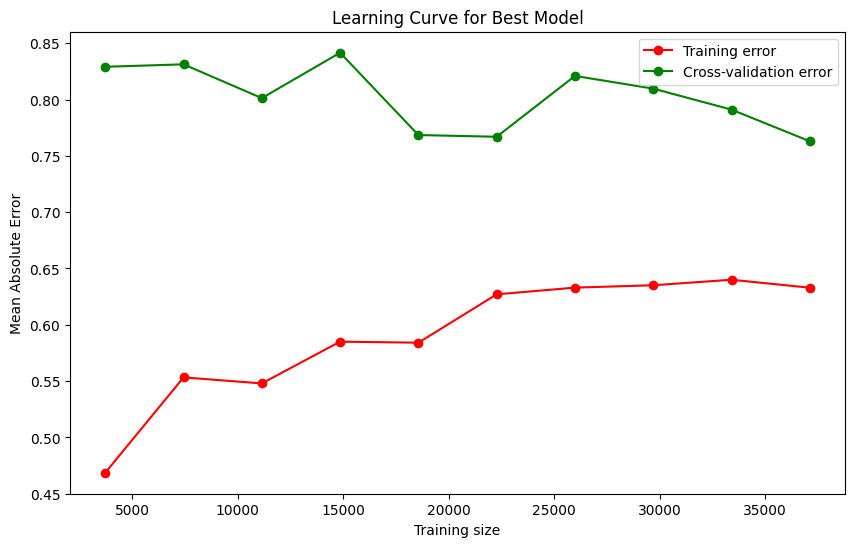

Predictions for all records saved successfully.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import time

# Load the complete dataset
data = pd.read_csv('./model_input.csv')

# Convert reservation_time to datetime
data['reservation_time'] = pd.to_datetime(data['reservation_time'])

# Extract month, hour, and weekday from reservation_time
data['month'] = data['reservation_time'].dt.month
data['hour'] = data['reservation_time'].dt.hour
data['weekday'] = data['reservation_time'].dt.weekday

# Split data into train+validation and hold-out test sets
train_val_data, hold_out_data = train_test_split(data, test_size=0.2, random_state=42)

# Further split train_val_data into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

# One-hot encode categorical features
def one_hot_encode(df, column_name):
    encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
    encoded = encoder.fit_transform(df[[column_name]])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out([column_name]), index=df.index)
    return encoder, encoded_df

month_encoder, month_encoded_train_df = one_hot_encode(train_data, 'month')
high_chair_encoder, high_chair_encoded_train_df = one_hot_encode(train_data, 'high_chair_size')
weekday_encoder, weekday_encoded_train_df = one_hot_encode(train_data, 'weekday')

# Combine all encoded features with the original data
train_data_encoded = pd.concat([train_data, month_encoded_train_df, high_chair_encoded_train_df, weekday_encoded_train_df], axis=1)

# Apply the same encoding to the validation and hold-out test data
def apply_encoding(df, month_encoder, high_chair_encoder, weekday_encoder):
    month_encoded = month_encoder.transform(df[['month']])
    high_chair_encoded = high_chair_encoder.transform(df[['high_chair_size']])
    weekday_encoded = weekday_encoder.transform(df[['weekday']])
    month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=df.index)
    high_chair_encoded_df = pd.DataFrame(high_chair_encoded.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=df.index)
    weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=df.index)
    return pd.concat([df, month_encoded_df, high_chair_encoded_df, weekday_encoded_df], axis=1)

val_data_encoded = apply_encoding(val_data, month_encoder, high_chair_encoder, weekday_encoder)
hold_out_data_encoded = apply_encoding(hold_out_data, month_encoder, high_chair_encoder, weekday_encoder)

# Define features including the hour and weekday features
features = ['party_size', 'queue_size', 'hour'] + list(month_encoded_train_df.columns) + list(high_chair_encoded_train_df.columns) + list(weekday_encoded_train_df.columns)
target = 'ETA'

# Function to handle negative and zero ETA values
def handle_negative_zero(df):
    df['ETA'] = df['ETA'].apply(lambda x: max(x, 0))
    return df

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42),
    'ElasticNet Regression': ElasticNet(random_state=42)
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Ridge Regression': {
        'alpha': [0.1, 1, 10, 100]
    },
    'Lasso Regression': {
        'alpha': [0.1, 1, 10, 100]
    },
    'ElasticNet Regression': {
        'alpha': [0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    'Decision Tree Regression': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost Regression': {
        'alpha': [0, 0.1, 1, 10],
        'lambda': [1, 2, 3],
        'gamma': [0, 0.1, 0.5, 1]
    }
}

# Store results including hyperparameter tuning
tuned_results = {}
model_objects = {}

# Iterate over each model
for model_name, model in models.items():
    start_time = time.time()  # Start time for computation time

    # Create copies of the data
    train_processed = train_data_encoded.copy()
    val_processed = val_data_encoded.copy()
    test_processed = hold_out_data_encoded.copy()

    # Handle negative and zero ETA values
    train_processed = handle_negative_zero(train_processed)
    val_processed = handle_negative_zero(val_processed)
    test_processed = handle_negative_zero(test_processed)

    # Define features (X) and target (y)
    X_train = train_processed[features]
    y_train = train_processed[target]
    X_val = val_processed[features]
    y_val = val_processed[target]
    X_test = test_processed[features]
    y_test = test_processed[target]

    if model_name in param_grids:
        # Perform grid search for regularization models
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Predict on validation and hold-out test sets
        y_val_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)

        # Calculate mean absolute error
        val_mae = mean_absolute_error(y_val, y_val_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # Store results and best model
        tuned_results[model_name] = {
            'Best Params': best_params,
            'Validation MAE': val_mae,
            'Test MAE': test_mae
        }
        model_objects[model_name] = best_model

    else:
        # Train the model
        model.fit(X_train, y_train)

        # Predict on the validation set
        y_val_pred = model.predict(X_val)
        # Predict on the hold-out test set
        y_test_pred = model.predict(X_test)

        # Calculate mean absolute error
        val_mae = mean_absolute_error(y_val, y_val_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        end_time = time.time()  # End time for computation time
        computation_time = end_time - start_time

        # Store results and model object
        tuned_results[model_name] = {
            'Validation MAE': val_mae,
            'Test MAE': test_mae,
            'Computation Time': computation_time
        }
        model_objects[model_name] = model

# Determine the best model based on validation MAE and computation time
best_model_name = None
best_val_mae = float('inf')
best_computation_time = float('inf')

for model_name, metrics in tuned_results.items():
    print(f"Model: {model_name}")
    print(f"Validation MAE = {metrics.get('Validation MAE', 'N/A'):.2f}, Test MAE = {metrics['Test MAE']:.2f}")
    if 'Computation Time' in metrics:
        print(f"Computation Time = {metrics['Computation Time']:.4f} seconds")
    if metrics['Validation MAE'] < best_val_mae or (metrics['Validation MAE'] == best_val_mae and metrics.get('Computation Time', float('inf')) < best_computation_time):
        best_model_name = model_name
        best_val_mae = metrics['Validation MAE']
        best_computation_time = metrics.get('Computation Time', float('inf'))

best_model = model_objects[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best Validation MAE: {best_val_mae:.2f}")
print(f"Computation Time: {best_computation_time:.4f} seconds")

# Function to prepare input data for prediction
def prepare_input_data(input_data, month_encoder, high_chair_encoder, weekday_encoder):
    input_df = pd.DataFrame([input_data])
    input_df['reservation_time'] = pd.to_datetime(input_df['reservation_time'])
    input_df['month'] = input_df['reservation_time'].dt.month
    input_df['hour'] = input_df['reservation_time'].dt.hour
    input_df['weekday'] = input_df['reservation_time'].dt.weekday

    month_encoded = month_encoder.transform(input_df[['month']])
    month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=input_df.index)

    high_chair_encoded = high_chair_encoder.transform(input_df[['high_chair_size']])
    high_chair_encoded_df = pd.DataFrame(high_chair_encoded.toarray(), columns=high_chair_encoder.get_feature_names_out(['high_chair_size']), index=input_df.index)

    weekday_encoded = weekday_encoder.transform(input_df[['weekday']])
    weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=input_df.index)

    input_encoded = pd.concat([input_df, month_encoded_df, high_chair_encoded_df, weekday_encoded_df], axis=1)
    return input_encoded[features]

# Example of preparing input data for prediction
input_data = {
    'reservation_time': '2024-07-16 00:30:00',
    'party_size': 8,
    'high_chair_size': 0,
    'queue_size': 8
}

prepared_input = prepare_input_data(input_data, month_encoder, high_chair_encoder, weekday_encoder)
predicted_eta = best_model.predict(prepared_input)
print(f"Predicted ETA: {predicted_eta[0]:.2f}")

# Plot the learning curve for the best model
X = train_data_encoded[features]
y = train_data_encoded[target]

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve for Best Model')
plt.legend(loc='best')
plt.show()

# Predict ETA for all records in the original dataset and save as predicted_eta
data_encoded = apply_encoding(data, month_encoder, high_chair_encoder, weekday_encoder)
data_encoded = handle_negative_zero(data_encoded)

X_data_encoded = data_encoded[features]
predicted_eta_all = best_model.predict(X_data_encoded)

data_encoded['predicted_eta'] = predicted_eta_all

# Predict ETA
data['predicted_eta'] = best_model.predict(X_data_encoded)
data['error'] = data['ETA'] - data['predicted_eta']
data.to_csv('./4.csv', index=False)

print("Predictions for all records saved successfully.")


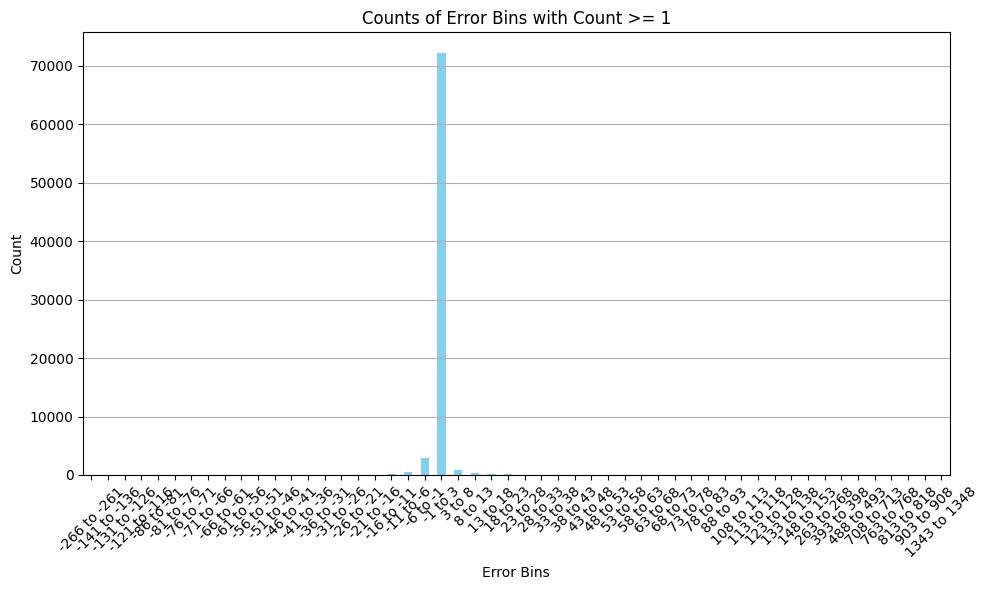

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = './4.csv'
data = pd.read_csv(data_path)

min_error = data['error'].min()
max_error = data['error'].max()

bin_edges = np.arange(min_error, max_error + 5, 5)

custom_bin_labels = [f"{int(bin_edges[i])} to {int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

data['error_bin'] = pd.cut(data['error'], bins=bin_edges, labels=custom_bin_labels, include_lowest=True, right=False)

bin_counts = data['error_bin'].value_counts().sort_index()

filtered_bins = bin_counts[bin_counts >= 1]

plt.figure(figsize=(10, 6))
filtered_bins.plot(kind='bar', color='skyblue')
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Counts of Error Bins with Count >= 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

data.to_csv('./4.csv')

In [ ]:
highest_count_bin = filtered_bins.idxmax()
filtered_data = data[data['error_bin'] == highest_count_bin]
sorted_data = filtered_data.sort_values(by='error_bin')
weekday_counts = sorted_data['weekday'].value_counts().sort_index()

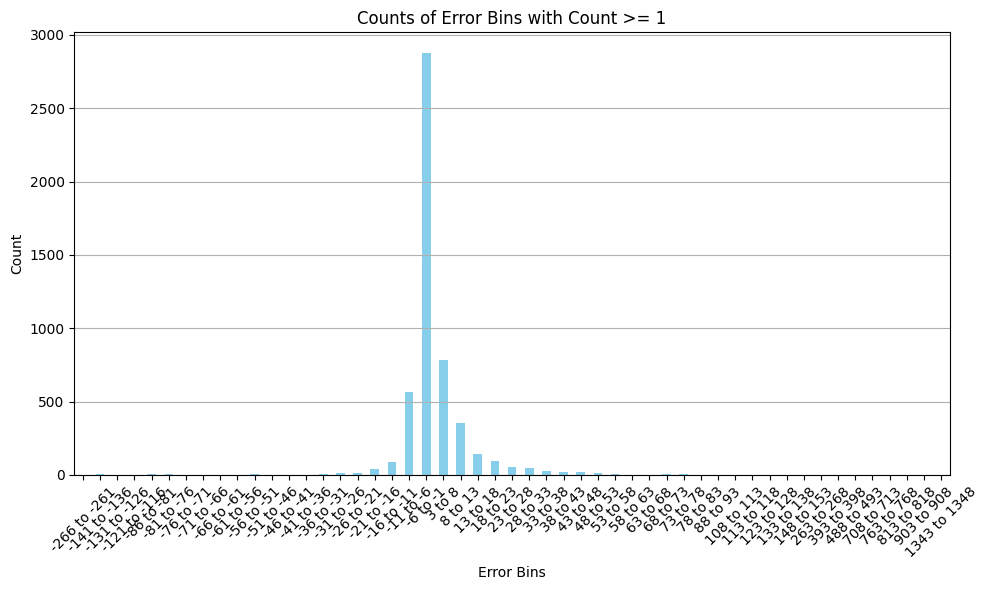

In [ ]:
data_bin = ['-1 to 3']
filtered_df = data[~data['error_bin'].isin(data_bin)]
bin_counts = filtered_df['error_bin'].value_counts().sort_index()

filtered_bins = bin_counts[bin_counts >= 1]

plt.figure(figsize=(10, 6))
filtered_bins.plot(kind='bar', color='skyblue')
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Counts of Error Bins with Count >= 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Sample data
data = pd.read_csv('./4.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Convert reservation_time to datetime
df['reservation_time'] = pd.to_datetime(df['reservation_time'])

# Extract the hour from reservation_time
df['hour'] = df['reservation_time'].dt.hour

# Create bins for hours
bins = [f"{hour}-{hour+1}" for hour in range(24)]
df['hour_bin'] = pd.cut(df['hour'], bins=range(25), right=False, labels=bins)

print(df[['reservation_time', 'hour_bin']])


               reservation_time hour_bin
0     2020-10-24 21:41:53+00:00    21-22
1     2020-10-24 21:42:32+00:00    21-22
2     2020-10-24 21:53:45+00:00    21-22
3     2020-10-24 21:54:09+00:00    21-22
4     2020-10-24 21:58:08+00:00    21-22
...                         ...      ...
77340 2024-06-30 01:44:23+00:00      1-2
77341 2024-06-30 01:47:41+00:00      1-2
77342 2024-07-03 01:33:07+00:00      1-2
77343 2024-07-04 01:38:22+00:00      1-2
77344 2024-07-04 01:45:45+00:00      1-2

[77345 rows x 2 columns]


C:\Users\Admin\AppData\Local\Temp\ipykernel_16480\2797676835.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_count = df.groupby(['hour_bin', 'error_bin']).size().unstack(fill_value=0)


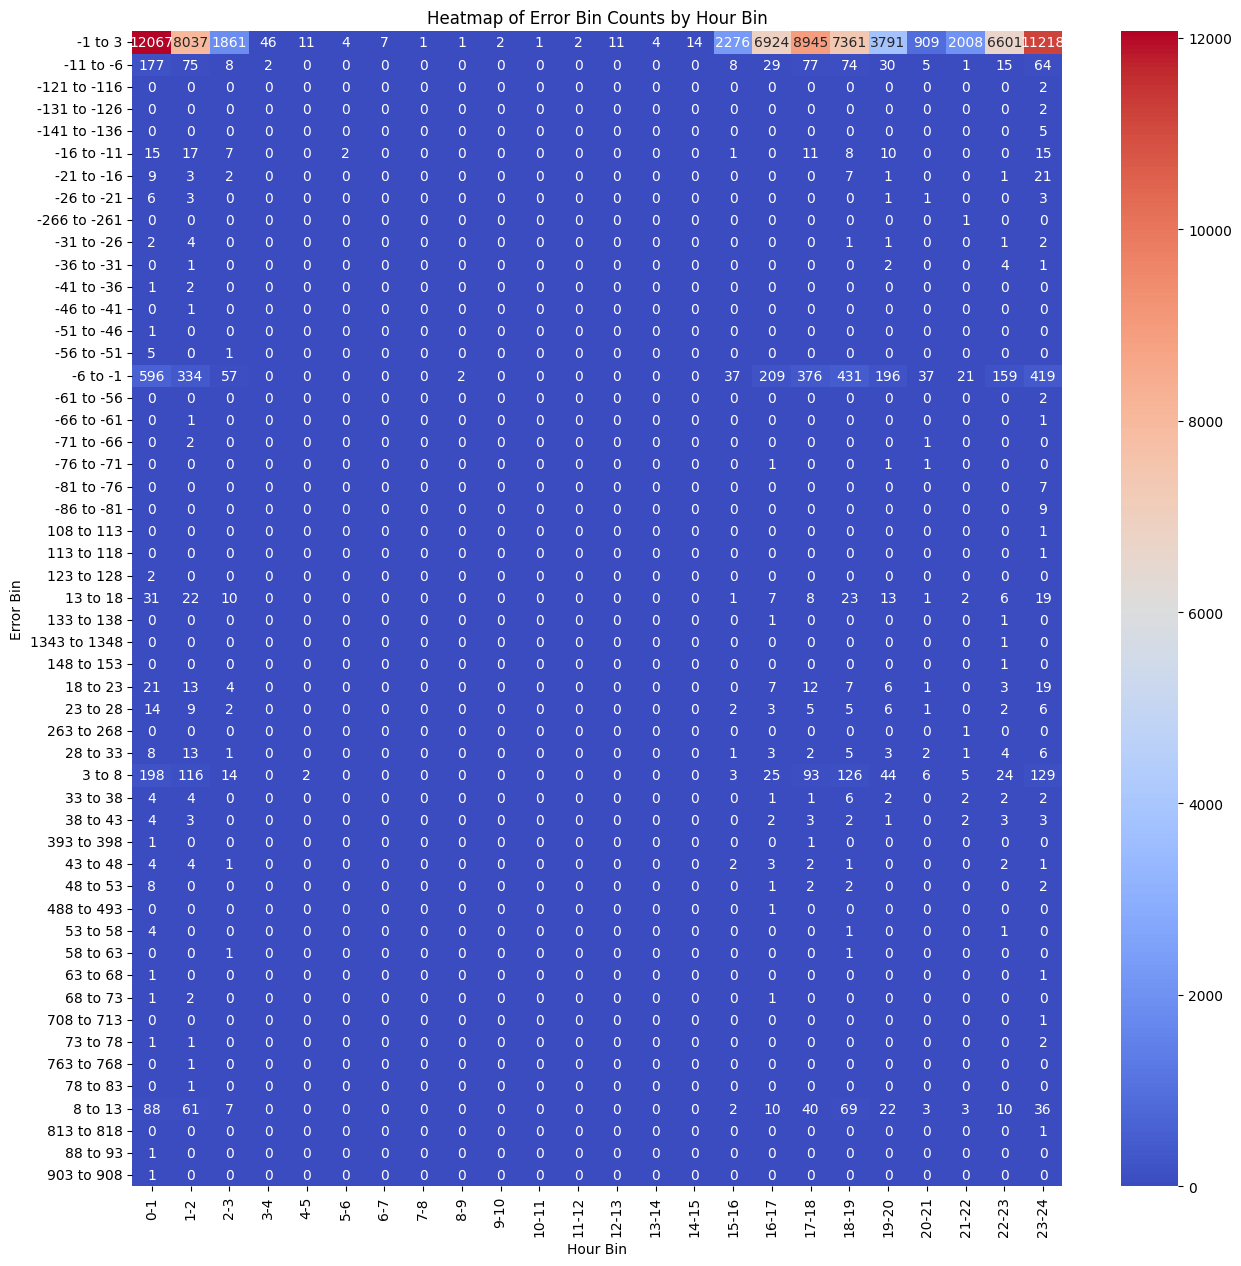

In [ ]:
import seaborn as sns
df['reservation_time'] = pd.to_datetime(df['reservation_time'])

# Create bins for hours
bins = [f"{hour}-{hour+1}" for hour in range(24)]
df['hour_bin'] = pd.cut(df['hour'], bins=range(25), right=False, labels=bins)

# Count the number of error_bin values falling under each hour_bin
error_count = df.groupby(['hour_bin', 'error_bin']).size().unstack(fill_value=0)

# Plot heatmap with x as hour_bin and y as error_bin
plt.figure(figsize=(15, 15))
sns.heatmap(error_count.T, annot=True, fmt='d', cmap='coolwarm')
plt.title('Heatmap of Error Bin Counts by Hour Bin')
plt.xlabel('Hour Bin')
plt.ylabel('Error Bin')
plt.show()

In [ ]:
# Categorize bins as negative and positive
df['bin_category'] = df['error_bin'].apply(lambda x: 'negative' if x.startswith('-') else 'positive')

# Count occurrences by bin category
bin_counts = df['bin_category'].value_counts()

# Print or use the counts
print("Negative Error Bins:")
negative_bins = df[df['bin_category'] == 'negative']['error_bin'].value_counts()
print(negative_bins)

print("\nPositive Error Bins:")
positive_bins = df[df['bin_category'] == 'positive']['error_bin'].value_counts()
print(positive_bins)

Negative Error Bins:
error_bin
-1 to 3         72102
-6 to -1         2874
-11 to -6         565
-16 to -11         86
-21 to -16         44
-26 to -21         14
-31 to -26         11
-86 to -81          9
-36 to -31          8
-81 to -76          7
-56 to -51          6
-141 to -136        5
-76 to -71          3
-41 to -36          3
-71 to -66          3
-61 to -56          2
-66 to -61          2
-121 to -116        2
-131 to -126        2
-266 to -261        1
-51 to -46          1
-46 to -41          1
Name: count, dtype: int64

Positive Error Bins:
error_bin
3 to 8          785
8 to 13         351
13 to 18        143
18 to 23         93
23 to 28         55
28 to 33         49
33 to 38         24
38 to 43         23
43 to 48         20
48 to 53         15
53 to 58          6
73 to 78          4
68 to 73          4
393 to 398        2
123 to 128        2
63 to 68          2
133 to 138        2
58 to 63          2
813 to 818        1
88 to 93          1
78 to 83          1
148 to 

## New

Model: Linear Regression
MAE = 1323420113.03, Computation Time = 1.1465 seconds
Model: Ridge Regression
MAE = 0.99, Computation Time = 0.3612 seconds
Model: Lasso Regression
MAE = 0.98, Computation Time = 0.3606 seconds
Model: Decision Tree Regression
MAE = 0.73, Computation Time = 0.4512 seconds
Model: XGBoost Regression
MAE = 0.70, Computation Time = 1.5322 seconds

Best Model: XGBoost Regression
Best MAE: 0.70
Computation Time: 1.5322 seconds


/var/folders/6w/9qtyzjdd3q3g7fk06nhhv8v00000gn/T/ipykernel_2792/1146906406.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_error_analysis = data.groupby(['weekday_name', 'error_bin']).size().unstack().fillna(0)
/var/folders/6w/9qtyzjdd3q3g7fk06nhhv8v00000gn/T/ipykernel_2792/1146906406.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_bin_error_analysis = data.groupby(['minute_bin', 'error_bin']).size().unstack().fillna(0)
/var/folders/6w/9qtyzjdd3q3g7fk06nhhv8v00000gn/T/ipykernel_2792/1146906406.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to 


Weekday to Error Bin Analysis:
 error_bin     <-30  -30 to -15  -15 to -5  -5 to 5  5 to 15  15 to 30  >30
weekday_name                                                              
Friday           4           7        112    10849       79        26   12
Monday           2           6        120     4578       69        18    7
Saturday         2          17        317    19419      266        45   32
Sunday           4          18        370    19193      242        57   33
Thursday         6           6         77     8289       35        15   17
Tuesday          1           2         46     4992       23         8    5
Wednesday        3           3         59     7792       41        13    8

Minute Bin to Error Bin Analysis:
 error_bin    <-30  -30 to -15  -15 to -5  -5 to 5  5 to 15  15 to 30  >30
minute_bin                                                               
00:00-00:15     0           1         60     3361       59         8   13
00:15-00:30     0           1     

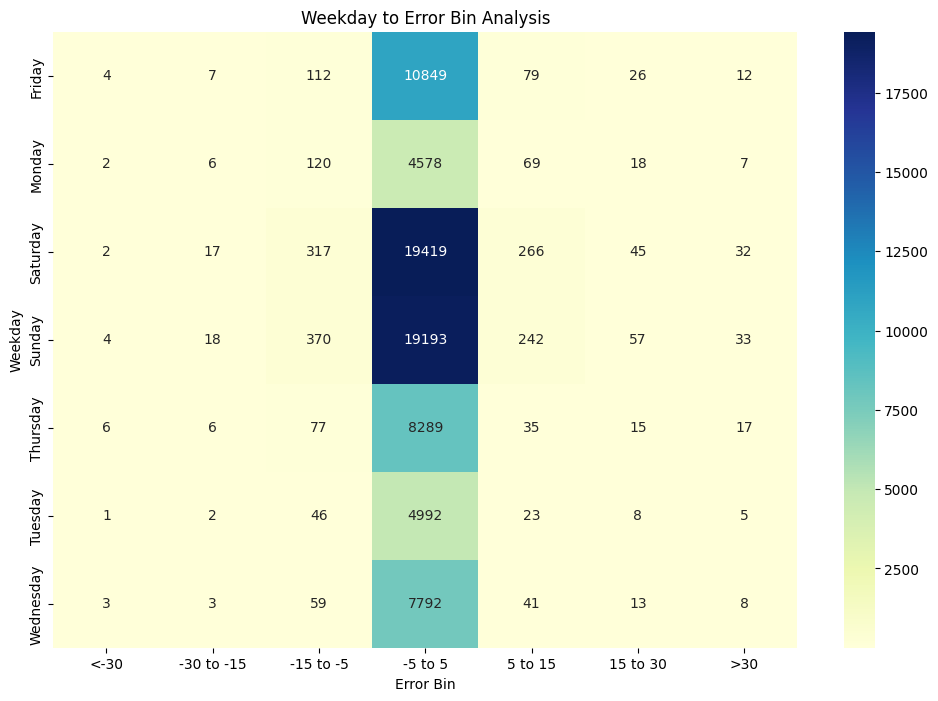

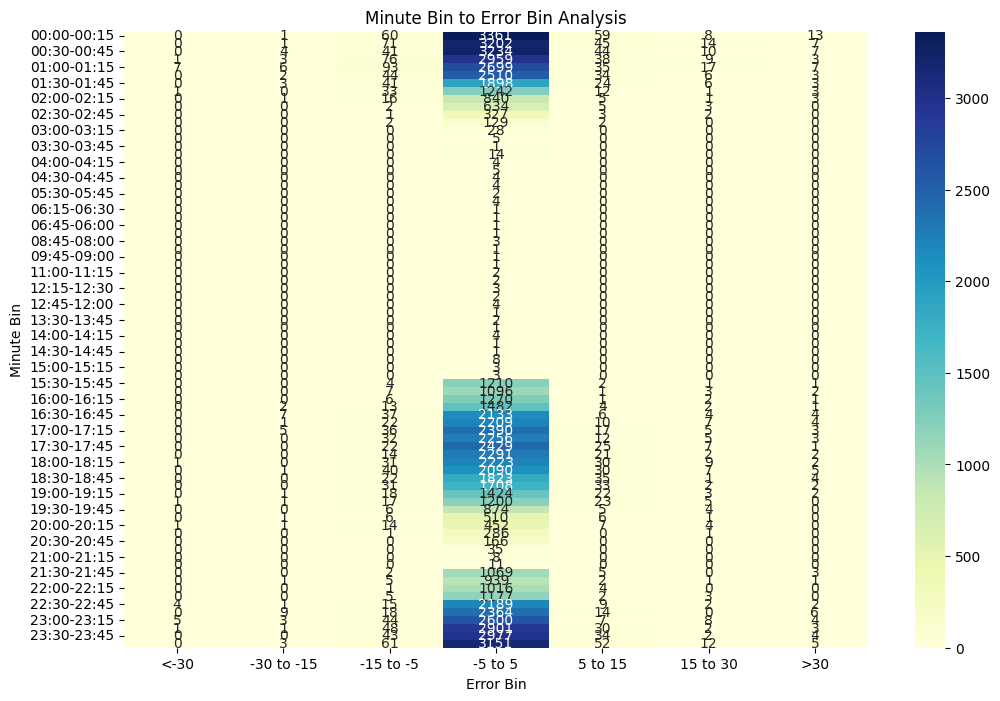

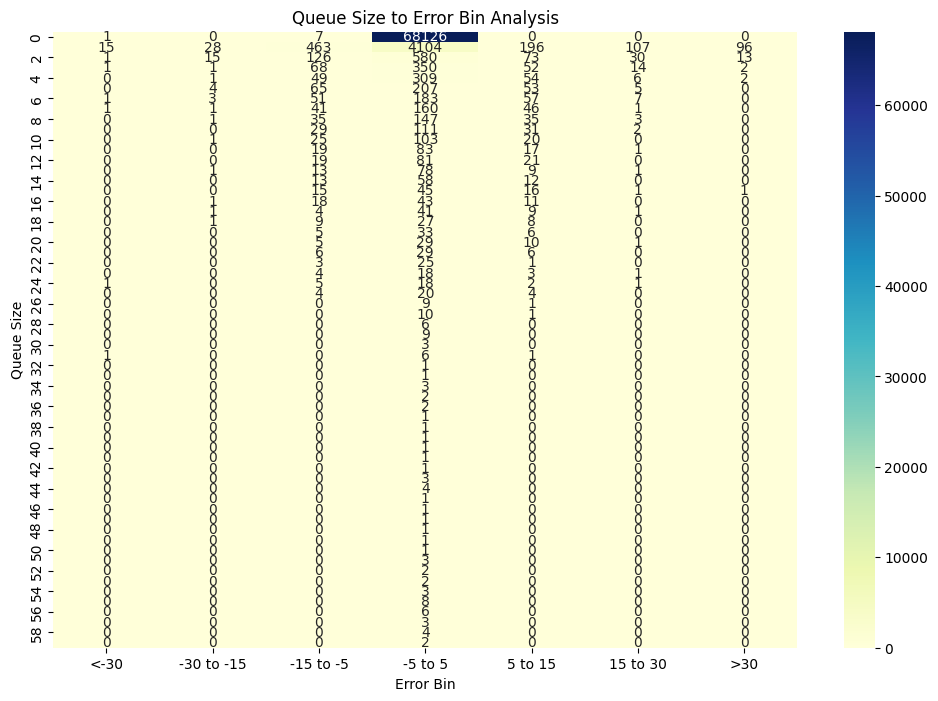

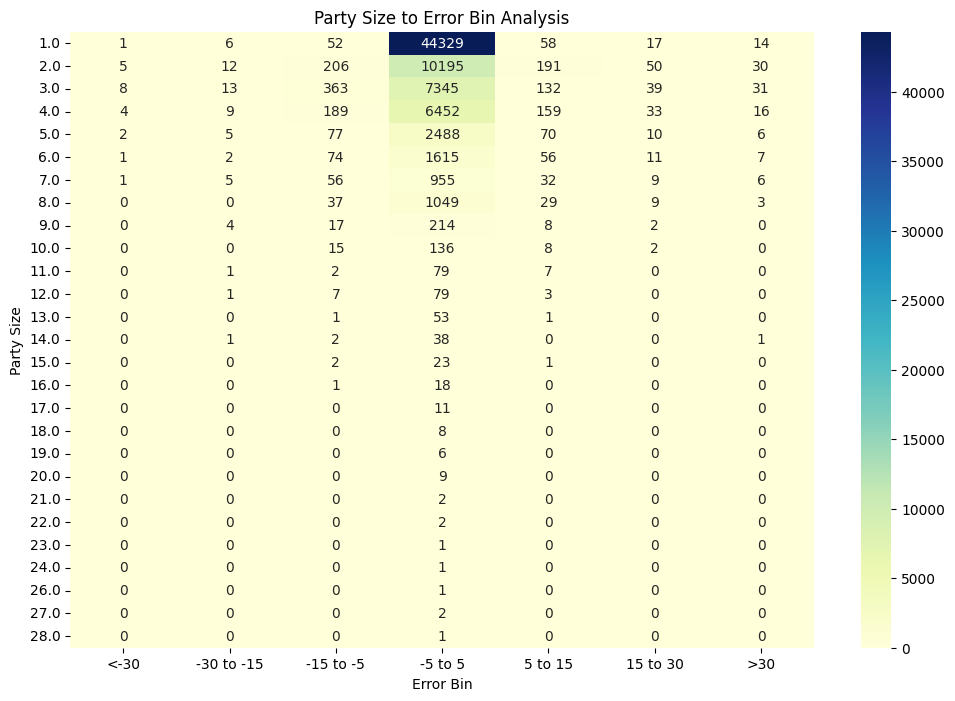

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the data
data = pd.read_csv('./model_input.csv')

# Convert reservation_time to datetime
data['reservation_time'] = pd.to_datetime(data['reservation_time'])

# Extract month, hour, weekday, and minute from reservation_time
data['month'] = data['reservation_time'].dt.month
data['hour'] = data['reservation_time'].dt.hour
data['weekday'] = data['reservation_time'].dt.weekday
data['minute'] = data['reservation_time'].dt.minute

# Map weekday numbers to weekday names
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
data['weekday_name'] = data['weekday'].map(weekday_map)

# Create minute-based bins with time intervals
def create_time_interval(hour, minute):
    start_minute = (hour * 60) + (minute // 15) * 15
    end_minute = start_minute + 15
    start_time = f"{hour:02d}:{start_minute % 60:02d}"
    end_time = f"{hour:02d}:{end_minute % 60:02d}"
    return f"{start_time}-{end_time}"

data['minute_bin'] = data.apply(lambda row: create_time_interval(row['hour'], row['minute']), axis=1)

# Encode high_chair_size: 1 if 1 or more, otherwise 0
data['high_chair_flag'] = data['high_chair_size'].apply(lambda x: 1 if x >= 1 else 0)

# One-hot encode the categorical features
month_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
month_encoded = month_encoder.fit_transform(data[['month']])
month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=data.index)

minute_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
minute_encoded = minute_encoder.fit_transform(data[['minute_bin']])
minute_encoded_df = pd.DataFrame(minute_encoded.toarray(), columns=minute_encoder.get_feature_names_out(['minute_bin']), index=data.index)

weekday_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
weekday_encoded = weekday_encoder.fit_transform(data[['weekday']])
weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=data.index)

# Combine all encoded features with the original data
data_encoded = pd.concat([data, month_encoded_df, minute_encoded_df, weekday_encoded_df], axis=1)

# Define features including the minute and weekday features
features = ['party_size', 'queue_size', 'high_chair_flag'] + list(month_encoded_df.columns) + list(minute_encoded_df.columns) + list(weekday_encoded_df.columns)
target = 'ETA'

# Function to handle negative or zero ETA values
def handle_negative_zero(df):
    df['ETA'] = df['ETA'].apply(lambda x: max(x, 0))
    return df

# Remove rows with missing ETA values
data_encoded = data_encoded.dropna(subset=['ETA'])

# Dictionary of models to be tested
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
}

# Training and evaluating models
results = {}
for model_name, model in models.items():
    start_time = time.time()
    df_processed = data_encoded.copy()
    df_processed = handle_negative_zero(df_processed)
    X = df_processed[features]
    y = df_processed[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    end_time = time.time()
    computation_time = end_time - start_time
    results[model_name] = {'MAE': mae, 'Computation Time': computation_time}

# Select the best model based on MAE
best_model = None
best_mae = float('inf')
best_computation_time = float('inf')
for model, metrics in results.items():
    print(f"Model: {model}")
    print(f"MAE = {metrics['MAE']:.2f}, Computation Time = {metrics['Computation Time']:.4f} seconds")
    if metrics['MAE'] < best_mae or (metrics['MAE'] == best_mae and metrics['Computation Time'] < best_computation_time):
        best_model = model
        best_mae = metrics['MAE']
        best_computation_time = metrics['Computation Time']
print(f"\nBest Model: {best_model}")
print(f"Best MAE: {best_mae:.2f}")
print(f"Computation Time: {best_computation_time:.4f} seconds")

# Predicting ETA for each row and calculating the error
best_model_instance = models[best_model]

# Ensure the feature DataFrame includes the non-one-hot encoded columns
data_encoded_features = pd.concat([data[['party_size', 'queue_size', 'high_chair_flag']], month_encoded_df, minute_encoded_df, weekday_encoded_df], axis=1)

# Predict ETA
data['predicted_eta'] = best_model_instance.predict(data_encoded_features)
data['error'] = data['ETA'] - data['predicted_eta']

# Create error bins
error_bins = [-float('inf'), -30, -15, -5, 5, 15, 30, float('inf')]
data['error_bin'] = pd.cut(data['error'], bins=error_bins, labels=['<-30', '-30 to -15', '-15 to -5', '-5 to 5', '5 to 15', '15 to 30', '>30'])

# Analysis by weekday and error bin
weekday_error_analysis = data.groupby(['weekday_name', 'error_bin']).size().unstack().fillna(0)
print("\nWeekday to Error Bin Analysis:\n", weekday_error_analysis)

# Analysis by minute bin and error bin
minute_bin_error_analysis = data.groupby(['minute_bin', 'error_bin']).size().unstack().fillna(0)
print("\nMinute Bin to Error Bin Analysis:\n", minute_bin_error_analysis)

queue_size_error_analysis = data.groupby(['queue_size', 'error_bin']).size().unstack().fillna(0)
print("\nQueue Size to Error Bin Analysis:\n", queue_size_error_analysis)

party_size_error_analysis = data.groupby(['party_size', 'error_bin']).size().unstack().fillna(0)
print("\nParty Size to Error Bin Analysis:\n", party_size_error_analysis)

# Save the results to a new CSV file
output_path = './predicted_eta_analysis.csv'
data.to_csv(output_path, index=False)

print(f"Predictions, errors, and analyses saved to {output_path}")

# Plotting the analyses
plt.figure(figsize=(12, 8))
sns.heatmap(weekday_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Weekday to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Weekday')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(minute_bin_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Minute Bin to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Minute Bin')
plt.show()

# Plotting the analysis for queue_size and error_bin
plt.figure(figsize=(12, 8))
sns.heatmap(queue_size_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Queue Size to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Queue Size')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(party_size_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Party Size to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Party Size')
plt.show()


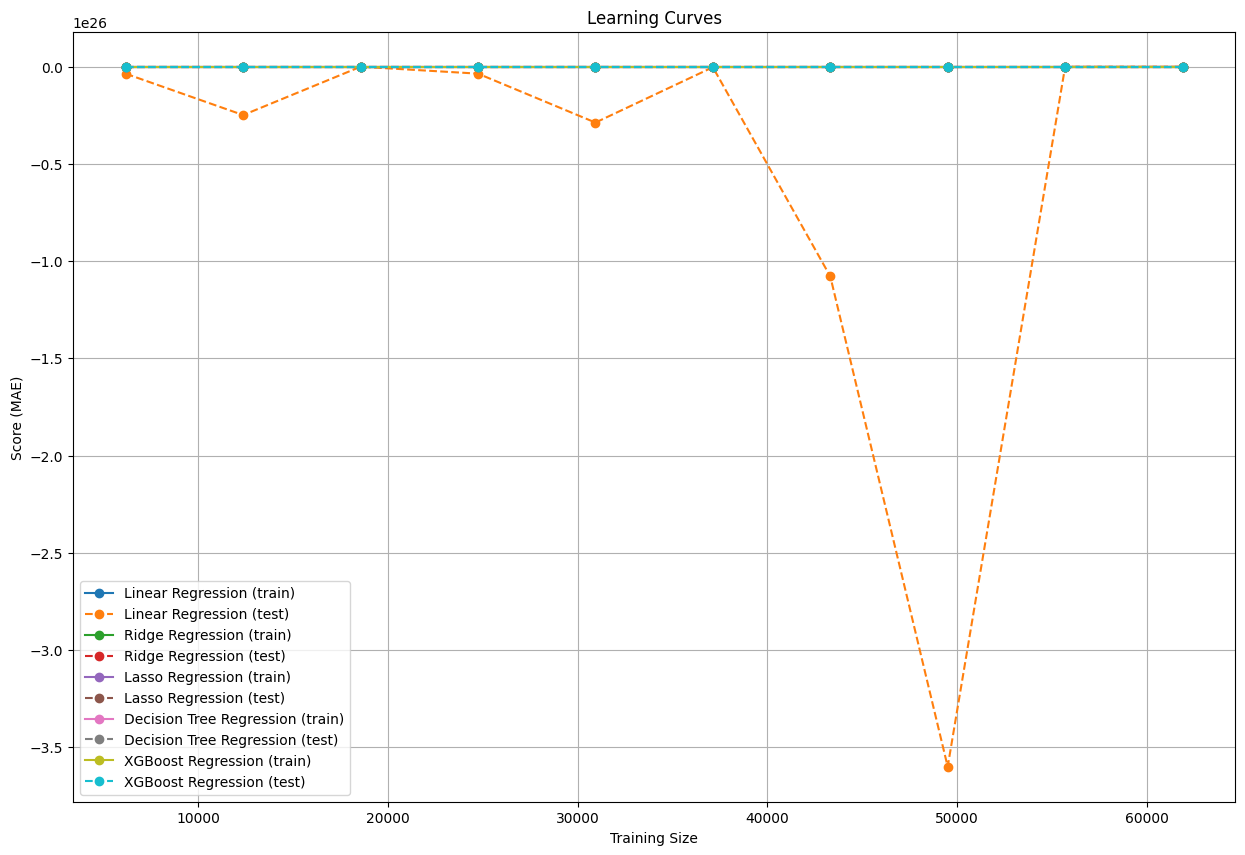

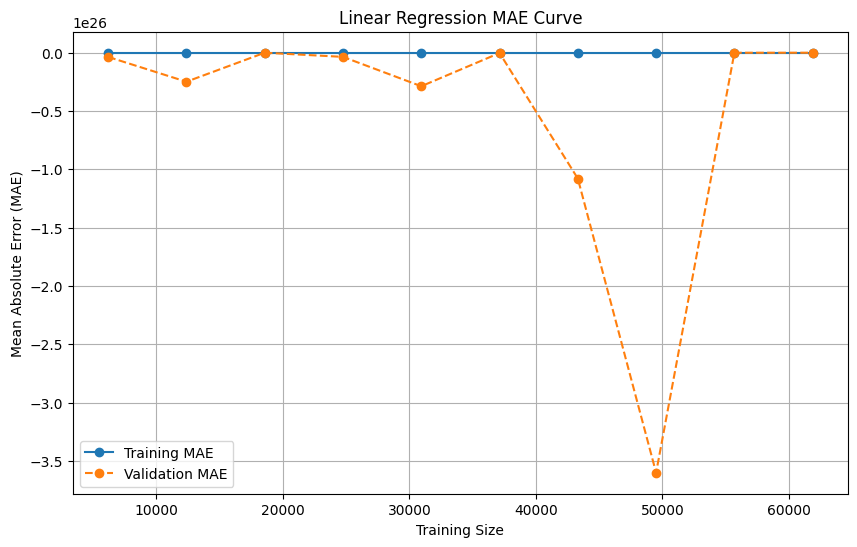

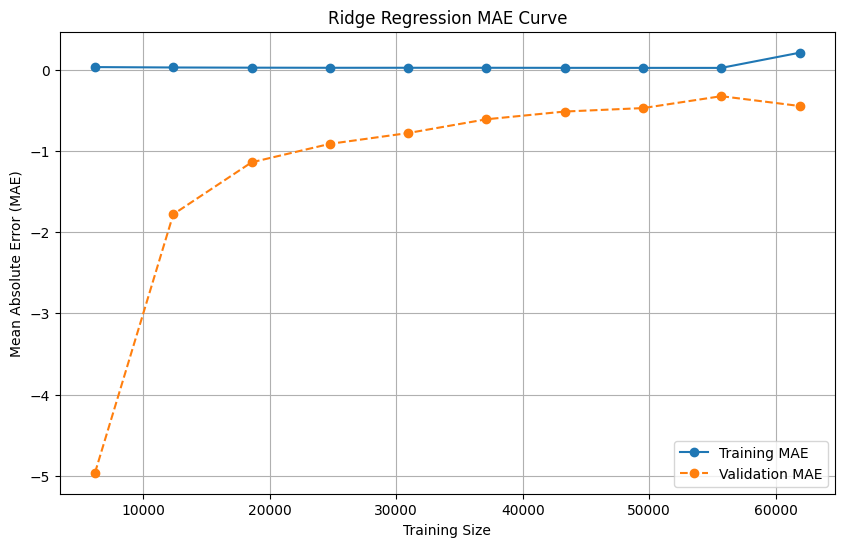

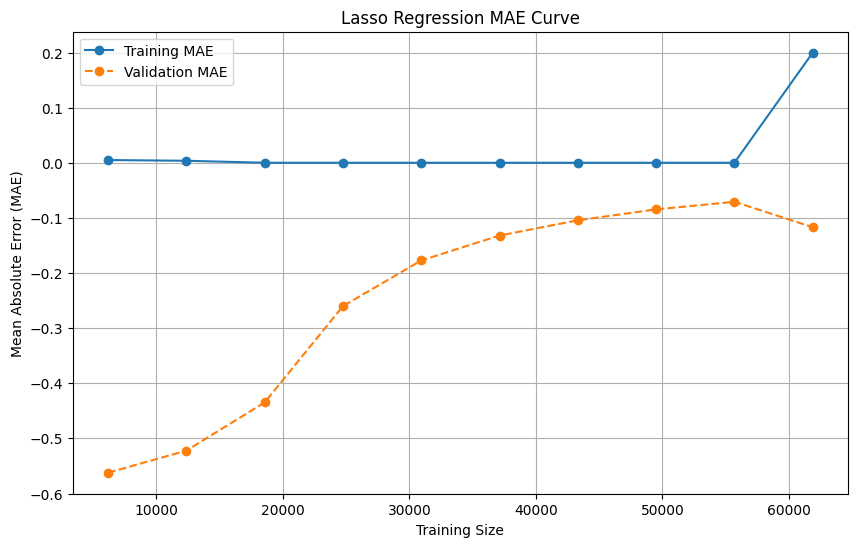

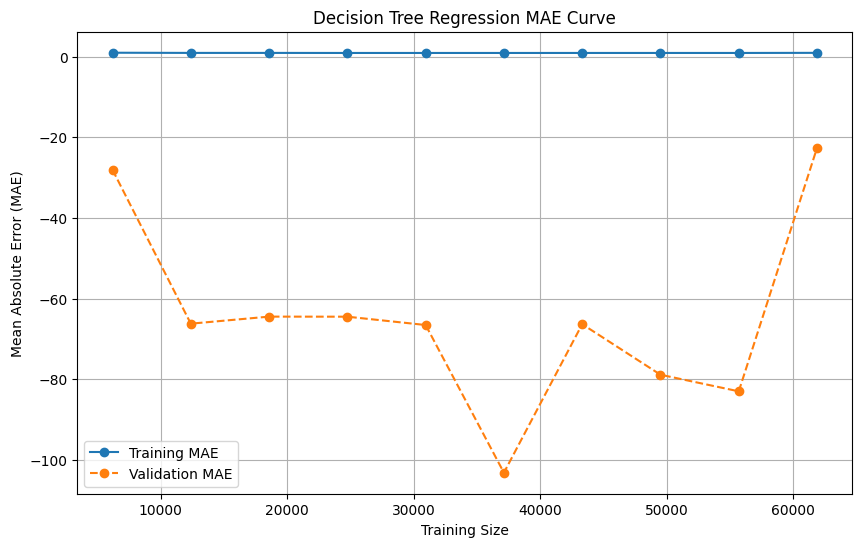

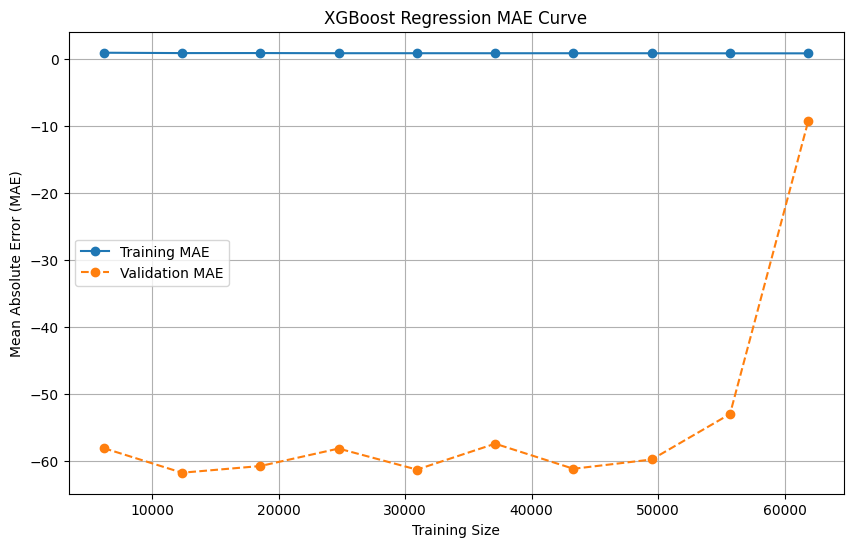

In [25]:
plt.figure(figsize=(15, 10))

for model_name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label=f'{model_name} (train)', linestyle='-', marker='o')
    plt.plot(train_sizes, test_mean, label=f'{model_name} (test)', linestyle='--', marker='o')

plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score (MAE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE curves
def plot_mae_curves(model_name, model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mae = np.mean(train_scores, axis=1)
    test_mae = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mae, label='Training MAE', linestyle='-', marker='o')
    plt.plot(train_sizes, test_mae, label='Validation MAE', linestyle='--', marker='o')
    plt.title(f'{model_name} MAE Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot MAE curves for each model
for model_name, model in models.items():
    plot_mae_curves(model_name, model, X, y)


## Stratified

Model: Linear Regression
MAE = 615939934.67, Computation Time = 10.0252 seconds
Model: Ridge Regression
MAE = 1.02, Computation Time = 1.9420 seconds
Model: Lasso Regression
MAE = 1.02, Computation Time = 2.2594 seconds
Model: Decision Tree Regression
MAE = 0.82, Computation Time = 3.7420 seconds
Model: XGBoost Regression
MAE = 0.77, Computation Time = 12.4891 seconds

Best Model: XGBoost Regression
Best MAE: 0.77
Computation Time: 12.4891 seconds


/var/folders/6w/9qtyzjdd3q3g7fk06nhhv8v00000gn/T/ipykernel_2792/1818506832.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_error_analysis = data.groupby(['weekday_name', 'error_bin']).size().unstack().fillna(0)
/var/folders/6w/9qtyzjdd3q3g7fk06nhhv8v00000gn/T/ipykernel_2792/1818506832.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_bin_error_analysis = data.groupby(['minute_bin', 'error_bin']).size().unstack().fillna(0)
/var/folders/6w/9qtyzjdd3q3g7fk06nhhv8v00000gn/T/ipykernel_2792/1818506832.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to 


Weekday to Error Bin Analysis:
 error_bin     <-30  -30 to -15  -15 to -5  -5 to 5  5 to 15  15 to 30  >30
weekday_name                                                              
Friday           0           3        107    10876       66        26   11
Monday           0           7         95     4603       73        13    9
Saturday         0           6        337    19424      251        47   33
Sunday           7           9        327    19239      247        53   35
Thursday         5           9         85     8278       39        15   14
Tuesday          0           2         29     5012       21         8    5
Wednesday        2           1         76     7781       41         8   10

Minute Bin to Error Bin Analysis:
 error_bin    <-30  -30 to -15  -15 to -5  -5 to 5  5 to 15  15 to 30  >30
minute_bin                                                               
00:00-00:15     0           1         71     3349       60         9   12
00:15-00:30     0           1     

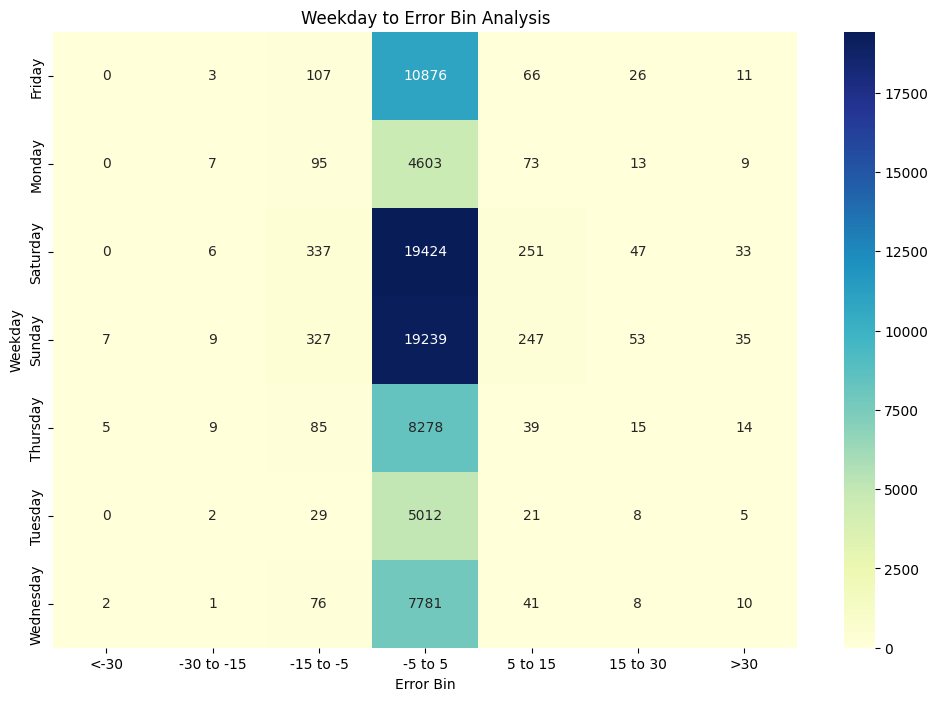

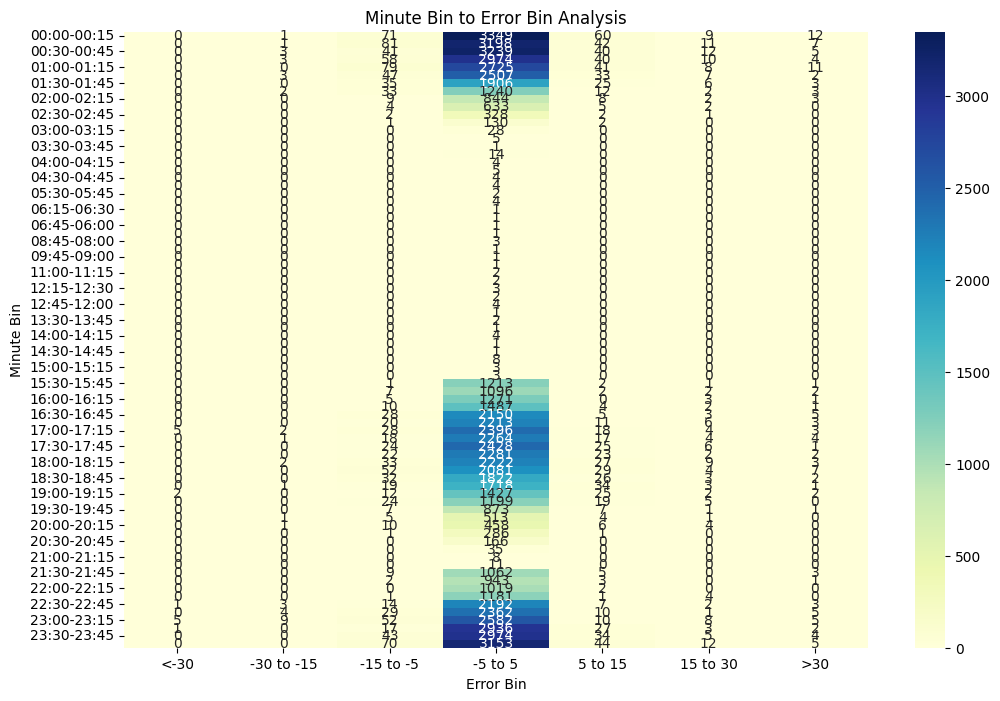

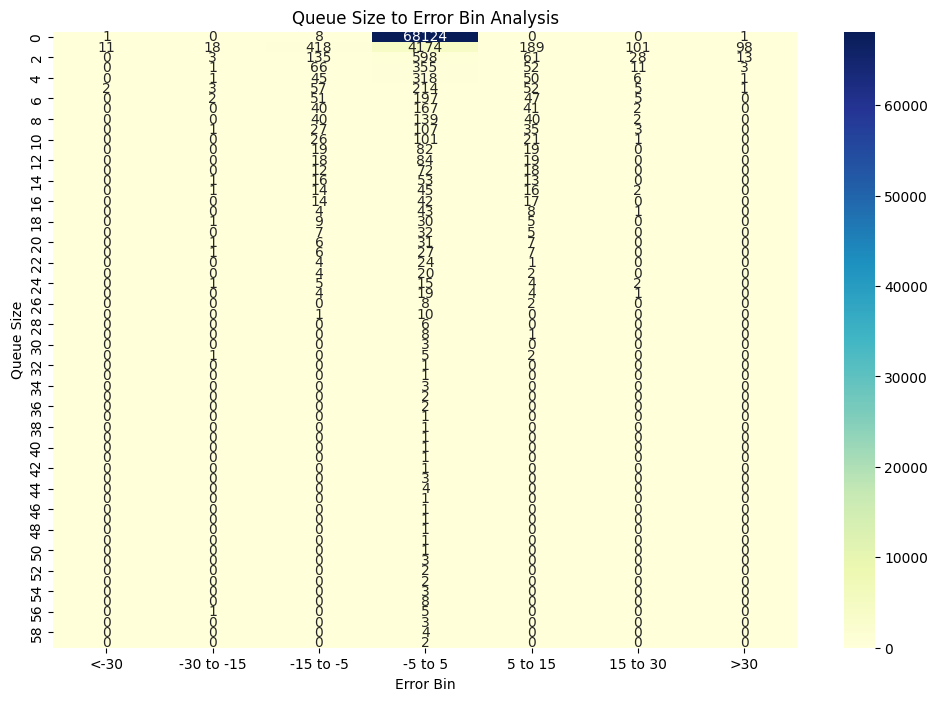

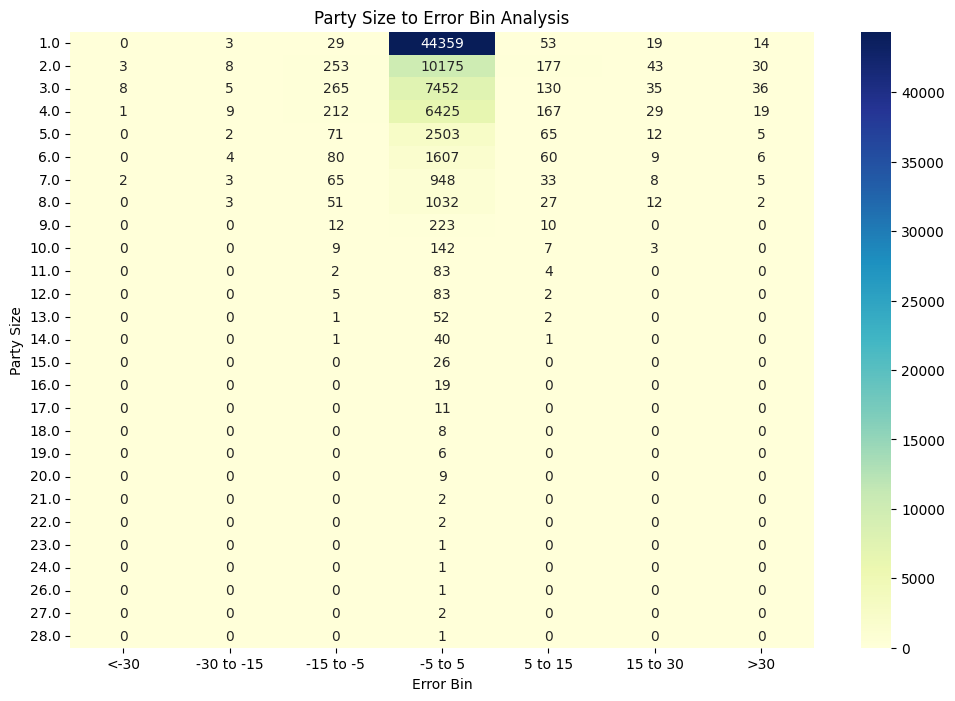

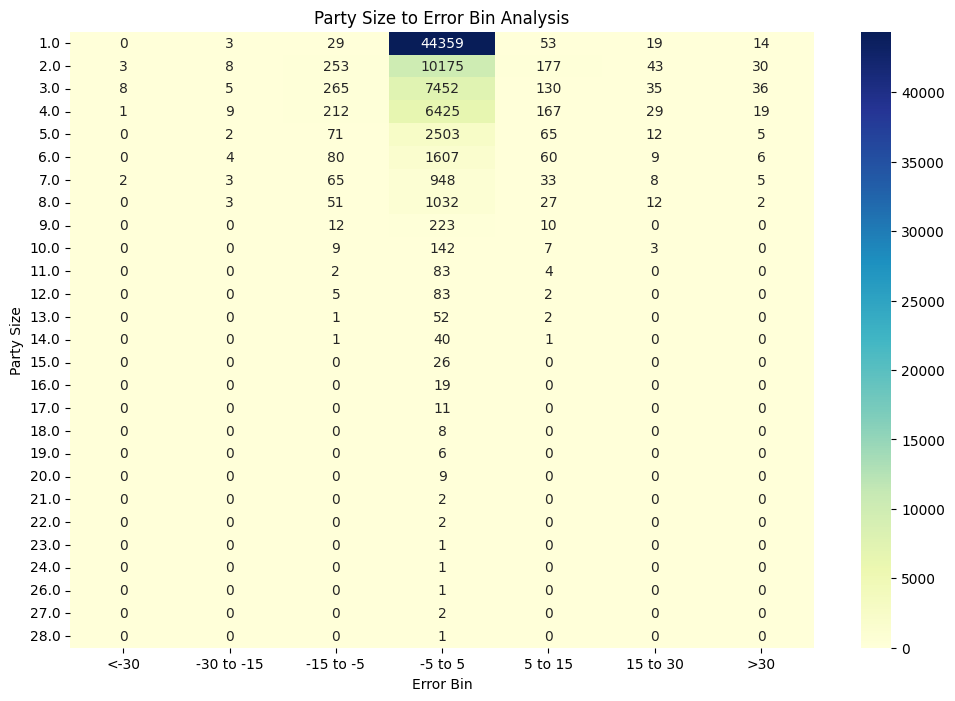

In [29]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the data
data = pd.read_csv('./model_input.csv')

# Convert reservation_time to datetime
data['reservation_time'] = pd.to_datetime(data['reservation_time'])

# Extract month, hour, weekday, and minute from reservation_time
data['month'] = data['reservation_time'].dt.month
data['hour'] = data['reservation_time'].dt.hour
data['weekday'] = data['reservation_time'].dt.weekday
data['minute'] = data['reservation_time'].dt.minute

# Map weekday numbers to weekday names
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
data['weekday_name'] = data['weekday'].map(weekday_map)

# Create minute-based bins with time intervals
def create_time_interval(hour, minute):
    start_minute = (hour * 60) + (minute // 15) * 15
    end_minute = start_minute + 15
    start_time = f"{hour:02d}:{start_minute % 60:02d}"
    end_time = f"{hour:02d}:{end_minute % 60:02d}"
    return f"{start_time}-{end_time}"

data['minute_bin'] = data.apply(lambda row: create_time_interval(row['hour'], row['minute']), axis=1)

# Encode high_chair_size: 1 if 1 or more, otherwise 0
data['high_chair_flag'] = data['high_chair_size'].apply(lambda x: 1 if x >= 1 else 0)

# One-hot encode the categorical features
month_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
month_encoded = month_encoder.fit_transform(data[['month']])
month_encoded_df = pd.DataFrame(month_encoded.toarray(), columns=month_encoder.get_feature_names_out(['month']), index=data.index)

minute_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
minute_encoded = minute_encoder.fit_transform(data[['minute_bin']])
minute_encoded_df = pd.DataFrame(minute_encoded.toarray(), columns=minute_encoder.get_feature_names_out(['minute_bin']), index=data.index)

weekday_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
weekday_encoded = weekday_encoder.fit_transform(data[['weekday']])
weekday_encoded_df = pd.DataFrame(weekday_encoded.toarray(), columns=weekday_encoder.get_feature_names_out(['weekday']), index=data.index)

# Combine all encoded features with the original data
data_encoded = pd.concat([data, month_encoded_df, minute_encoded_df, weekday_encoded_df], axis=1)

# Define features including the minute and weekday features
features = ['party_size', 'queue_size', 'high_chair_flag'] + list(month_encoded_df.columns) + list(minute_encoded_df.columns) + list(weekday_encoded_df.columns)
target = 'ETA'

# Function to handle negative or zero ETA values
def handle_negative_zero(df):
    df['ETA'] = df['ETA'].apply(lambda x: max(x, 0))
    return df

# Remove rows with missing ETA values
data_encoded = data_encoded.dropna(subset=['ETA'])

# Dictionary of models to be tested
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
}

# Function for KFold split
def kfold_split(df, n_splits=15):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(df):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]
        yield train_data, test_data

# Training and evaluating models using KFold split
results = {}
for model_name, model in models.items():
    start_time = time.time()
    df_processed = data_encoded.copy()
    df_processed = handle_negative_zero(df_processed)
    
    mae_list = []
    computation_time_list = []
    
    for train_data, test_data in kfold_split(df_processed):
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)
        computation_time_list.append(time.time() - start_time)
    
    results[model_name] = {'MAE': np.mean(mae_list), 'Computation Time': np.mean(computation_time_list)}

# Select the best model based on MAE
best_model = None
best_mae = float('inf')
best_computation_time = float('inf')
for model, metrics in results.items():
    print(f"Model: {model}")
    print(f"MAE = {metrics['MAE']:.2f}, Computation Time = {metrics['Computation Time']:.4f} seconds")
    if metrics['MAE'] < best_mae or (metrics['MAE'] == best_mae and metrics['Computation Time'] < best_computation_time):
        best_model = model
        best_mae = metrics['MAE']
        best_computation_time = metrics['Computation Time']
print(f"\nBest Model: {best_model}")
print(f"Best MAE: {best_mae:.2f}")
print(f"Computation Time: {best_computation_time:.4f} seconds")

# Predicting ETA for each row and calculating the error
best_model_instance = models[best_model]

# Ensure the feature DataFrame includes the non-one-hot encoded columns
data_encoded_features = pd.concat([data[['party_size', 'queue_size', 'high_chair_flag']], month_encoded_df, minute_encoded_df, weekday_encoded_df], axis=1)

# Predict ETA
data['predicted_eta'] = best_model_instance.predict(data_encoded_features)
data['error'] = data['ETA'] - data['predicted_eta']

# Create error bins
error_bins = [-float('inf'), -30, -15, -5, 5, 15, 30, float('inf')]
data['error_bin'] = pd.cut(data['error'], bins=error_bins, labels=['<-30', '-30 to -15', '-15 to -5', '-5 to 5', '5 to 15', '15 to 30', '>30'])

# Analysis by weekday and error bin
weekday_error_analysis = data.groupby(['weekday_name', 'error_bin']).size().unstack().fillna(0)
print("\nWeekday to Error Bin Analysis:\n", weekday_error_analysis)

# Analysis by minute bin and error bin
minute_bin_error_analysis = data.groupby(['minute_bin', 'error_bin']).size().unstack().fillna(0)
print("\nMinute Bin to Error Bin Analysis:\n", minute_bin_error_analysis)

queue_size_error_analysis = data.groupby(['queue_size', 'error_bin']).size().unstack().fillna(0)
print("\nQueue Size to Error Bin Analysis:\n", queue_size_error_analysis)

party_size_error_analysis = data.groupby(['party_size', 'error_bin']).size().unstack().fillna(0)
print("\nParty Size to Error Bin Analysis:\n", party_size_error_analysis)

# Save the results to a new CSV file
output_path = './predicted_stratified.csv'
data.to_csv(output_path, index=False)

print(f"Predictions, errors, and analyses saved to {output_path}")

# Plotting the analyses
plt.figure(figsize=(12, 8))
sns.heatmap(weekday_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Weekday to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Weekday')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(minute_bin_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Minute Bin to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Minute Bin')
plt.show()

# Plotting the analysis for queue_size and error_bin
plt.figure(figsize=(12, 8))
sns.heatmap(queue_size_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Queue Size to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Queue Size')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(party_size_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Party Size to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Party Size')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(party_size_error_analysis, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Party Size to Error Bin Analysis')
plt.xlabel('Error Bin')
plt.ylabel('Party Size')
plt.show()
